---

**Task**

- Îã§ÏñëÌïú ÏãúÍ≥ÑÏó¥ Í≥ºÏóÖ(ÏóêÏ∏°, Ïù¥ÏÉÅÏπò ÌÉêÏßÄ, Î∂ÑÎ•ò)Îì§Ïóê ÎåÄÌïú ÌîÑÎ†àÏûÑÏõåÌÅ¨ Íµ¨ÏÑ±

**Dataset**

- ÏòàÏ∏°(ETTh1), Ïù¥ÏÉÅÏπò ÌÉêÏßÄ(PSM), Î∂ÑÎ•ò(UEA)Ïùò Î≤§ÏπòÎßàÌÅ¨ Îç∞Ïù¥ÌÑ∞ÏÖã Ïù¥Ïö©

**Code**

- Î™®Îì† Í≥ºÏóÖ ÏàòÌñâÏóê ÎåÄÌï¥ÏÑú ÏÇ¨Ïö©Í∞ÄÎä•Ìïú Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± Î∞è Î™®Îç∏ÎßÅ ÏßÑÌñâÌïòÎ©∞, ÏÑ±Îä• ÌèâÍ∞Ä Í∞ÄÎä•ÌïúÏßÄ ÌôïÏù∏
- Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù Î∞è Ï†ÑÏ≤òÎ¶¨ - Îç∞Ïù¥ÌÑ∞ÏÖã Î∞è Î°úÎçî Íµ¨ÏÑ± - Î™®Îç∏ Íµ¨Ï∂ï Î∞è ÌïôÏäµ - ÏÑ±Îä• ÌèâÍ∞Ä Î∞è Í≤∞Í≥º Ìï¥ÏÑù
- Í∏∞Ï°¥ Î™®Îç∏ ÏΩîÎìú Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö© Í∏àÏßÄ

**Submit**

- Î™®Îì† Í≥ºÏ†ïÏóê ÎåÄÌïú Î™ÖÌôïÌïú Í∑ºÍ±∞ÏôÄ ÏÑ§Î™Ö Î¨∏ÏÑúÌôî
- Ïã§Ìóò Í≤∞Í≥ºÏùò Î°úÍπÖ Î∞è ÏãúÍ∞ÅÌôî
- Ï†úÏ∂ú ÌååÏùºÏùÄ README, Ï£ºÌîºÌÑ∞ ÎÖ∏Ìä∏Î∂Å ÌòïÌÉúÎ°ú Í∞úÏù∏ repoÏóê push Ìïú Îã§Ïùå repo ÎßÅÌÅ¨Î•º Ï†úÏ∂ú

---

## Ï¥àÍ∏∞ÏÑ§Ï†ï

In [20]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [21]:
# ÌïÑÏöî ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò
!pip install omegaconf
!pip install aeon
!pip install numba
!pip install awkward

In [22]:
# Í∏∞Î≥∏ ÎùºÏù¥Î∏åÎ¶¨Îü¨Î¶¨
import torch
from torch.utils.data import DataLoader

import numpy as np
import os
import json
import shutil
import logging
import warnings
warnings.filterwarnings("ignore")

from glob import glob

from accelerate import Accelerator, DistributedDataParallelKwargs
from accelerate.logging import get_logger
from accelerate.utils import set_seed

from omegaconf import OmegaConf

################### Ï∂îÍ∞Ä ÎùºÏù¥Î∏åÎü¨Î¶¨(Ïù¥Ïö©Ïãú) ######################

import pandas as pd
import aeon
from scipy import stats
from scipy.signal import periodogram
from scipy.io import arff
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from aeon.datasets import load_from_ts_file
from statsmodels.tsa.seasonal import seasonal_decompose
import awkward as ak
from numba import jit, njit, prange
import time
import torch.nn.functional as F
import math
import copy
import json
from sklearn.metrics import roc_auc_score, roc_curve
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader




############################################################

---

In [23]:
# Training argument
config = {
    "DEFAULT": {
        "exp_name": "forecasting",
        "seed": 42
    },
    "DATASET": {
        "taskname": "long_term_forecast",
        "dataname": "custom",
        "sub_data_name": None,
        "scaler": "standard",
        "window_size": 96,
        "label_len": 0,
        "pred_len": 96,
        "model_type": "forecasting",
        "pretrain": False,
        "split_rate": [0.7, 0.1, 0.2],
        "timeenc": 0,
        "freq": "h",
        "embed_type": "learned"
    },
    "DATAINFO": {
        "datadir": "./dataset",
        "train_path": "",
        "valid_path": "",
        "test_path": "",
        "test_label_path": ""
    },
    "TRAIN": {
        "epoch": 30,
        "batch_size": 64,
        "test_batch_size": 128,
        "num_workers": 0,
        "ckp_metric": "MSE",
        "eval_epochs": 1,
        "log_epochs": 1,
        "log_eval_iter": 50,
        "shuffle": False,
        "pin_memory": True,
        "resume": False,
        "resume_number": 0,
        "early_stopping_metric": "loss",
        "early_stopping_count": 20,
        "return_output": True,
        "lradj": "type1",
        "wandb": {
            "use": False,
            "iter": 50,
            "exp_name": "default",
            "project_name": "TMAE",
            "entity": "A"
        }
    },
    "LOSS": {
        "loss_name": "MSELoss"
    },
    "OPTIMIZER": {
        "opt_name": "AdamW",
        "lr": 0.0001,
        "params": {
            "weight_decay": 0.0005
        }
    },
    "RESULT": {
        "savedir": "./saved_model"
    }
}

# Model arguments
models_config = {
        "MyDiffusionModel": {
        "input_size": 16,       # ÏûÖÎ†• ÌîºÏ≤ò Ïàò
        "hidden_size": 16,     # ÌûàÎì† Ï∞®Ïõê
        "num_layers": 1,       # Í≥ÑÏ∏µ Ïàò
        "dropout": 0.2,        # ÎìúÎ°≠ÏïÑÏõÉ ÎπÑÏú®
        "enc_in": 16,
        "seq_len" : 336,
        "d_model" : 16,
        "output_size": 1       # Ï∂úÎ†• Ï∞®Ïõê(Ïòà: ÌöåÍ∑ÄÎùºÎ©¥ 1)

        }
##################### EDIT YOUR CODE #########################
# EX)
#     "YOUR_MODEL": {
#         "enc_in": 125,
#         "dropout": 0.1
#     }
##############################################################
}

cfg = OmegaConf.create(config)

##################### EDIT YOUR CODE #########################
# EX)
# cfg = OmegaConf.merge(cfg, {'MODEL':{'modelname' : 'YOUR_MODEL'}})
##############################################################
cfg = OmegaConf.merge(cfg, {'MODEL':{'modelname' : 'MyDiffusionModel'}})



model_cfg = OmegaConf.create(models_config)
modelname = cfg.MODEL.modelname

if modelname in model_cfg:
    model_setting_conf = OmegaConf.create(model_cfg[cfg.MODEL.modelname])
    cfg = OmegaConf.merge(cfg, {'MODELSETTING' : model_setting_conf})
else:
    print(f"Model '{modelname}' not found in the model_config.")


In [24]:
base_cfg = OmegaConf.create(config)

def build_task_cfg(
    base_cfg,
    models_config,
    taskname,
    dataname,
    loss_name,
    modelname,
    data_info_update=None,
    dataset_update=None,
):
    # 1. baseÏóêÏÑú Î≥µÏ†ú Î∞è task Ï†ïÎ≥¥ ÎçÆÏñ¥Ïì∞Í∏∞
    update_dict = {
        'DATASET': {'taskname': taskname, 'dataname': dataname},
        'DATAINFO': {'dataname': dataname},
        'LOSS': {'loss_name': loss_name},
        'MODEL': {'modelname': modelname},
    }
    if data_info_update:
        update_dict['DATAINFO'].update(data_info_update)
    if dataset_update:
        update_dict['DATASET'].update(dataset_update)
    # base merge
    cfg = OmegaConf.merge(base_cfg, update_dict)

    # 2. Î™®Îç∏ ÏÑ∏Î∂Ä ÌååÎùºÎØ∏ÌÑ∞ ÏûêÎèô merge
    model_cfg = OmegaConf.create(models_config)
    if modelname in model_cfg:
        model_setting_conf = OmegaConf.create(model_cfg[modelname])
        cfg = OmegaConf.merge(cfg, {'MODELSETTING': model_setting_conf})
    else:
        print(f"Model '{modelname}' not found in the model_config.")

    return cfg

# ==== ÏÇ¨Ïö© ÏòàÏãú ====

base_cfg = OmegaConf.create(config)

forecast_cfg = build_task_cfg(
    base_cfg, models_config,
    taskname='long_term_forecast',
    dataname='ETTh1',
    loss_name='MSELoss',
    modelname='MyDiffusionModel'
)

anomaly_cfg = build_task_cfg(
    base_cfg, models_config,
    taskname='anomaly_detection',
    dataname='PSM',
    loss_name='BCELoss',
    modelname='MyDiffusionModel'
)

classification_cfg = build_task_cfg(
    base_cfg, models_config,
    taskname='classification',
    dataname='Libras',
    loss_name='CrossEntropyLoss',
    modelname='MyDiffusionModel'
)


---

In [25]:
def make_save(accelerator, savedir: str, resume: bool = False) -> str:
    # resume
    if resume:
        assert os.path.isdir(savedir), f'{savedir} does not exist'
        # check version
        version = len([f for f in glob.glob(os.path.join(savedir, '*')) if os.path.isdir(f)])
        # init version
        if version == 0:
            files = [f for f in glob.glob(os.path.join(savedir, '*')) if os.path.isfile(f)]
            version0_dir = os.path.join(savedir, f'train{version}')

            accelerator.wait_for_everyone()
            if accelerator.is_main_process:
                os.makedirs(version0_dir)
                for f in files:
                    shutil.move(f, f.replace(savedir, version0_dir))
            version += 1

        savedir = os.path.join(savedir, f'train{version}')
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        os.makedirs(savedir, exist_ok=True)
    print("make save directory {}".format(savedir))

    return savedir


In [26]:
_logger = get_logger('train')

# set seed
set_seed(cfg.DEFAULT.seed)

# set accelrator
accelerator = Accelerator()

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
    )

# make save directory
savedir = os.path.join(cfg.RESULT.savedir, cfg.MODEL.modelname, cfg.DEFAULT.exp_name)
savedir = make_save(accelerator = accelerator, savedir=savedir, resume=cfg.TRAIN.resume)

# set device
_logger.info('Device: {}'.format(accelerator.device), main_process_only=False)

make save directory ./saved_model/MyDiffusionModel/forecasting


## 1. Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù Î∞è Ï†ÑÏ≤òÎ¶¨

    1-1) Ï†úÍ≥µÎêú Îç∞Ïù¥ÌÑ∞Ïóê Í∏∞Î≥∏Ï†ÅÏù∏ Î∂ÑÏÑù ÏßÑÌñâ (ÌÜµÍ≥ÑÎüâ Î∂ÑÏÑù, Í≤∞Ï∏°Ïπò ÌôïÏù∏, Ï†ïÏÉÅÏÑ± Î∂ÑÏÑù, ÏãúÍ≥ÑÏó¥ Î∂ÑÌï¥ Îì±)
    1-2) ÌôïÏù∏Îêú ÌäπÏÑ±ÏùÑ Î∞òÏòÅÌïòÏó¨ Ï†ÑÏ≤òÎ¶¨ ÏßÑÌñâ (Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨, Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨, Ï†ïÍ∑úÌôî Îì±)
    1-3) Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Î•º Î∞îÌÉïÏúºÎ°ú Îã§Ïãú ÌïúÎ≤à Î∂ÑÏÑù ÏßÑÌñâ ÌõÑ ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ Í∏∞Ïà† (ÌÜµÍ≥ÑÎüâ Î∂ÑÏÑù, Í≤∞Ï∏°Ïπò ÌôïÏù∏, Ï†ïÏÉÅÏÑ± Î∂ÑÏÑù, ÏãúÍ≥ÑÏó¥ Î∂ÑÌï¥ Îì±)
    1-4) ÏàòÏ†ï ÎÇ¥Ïö©ÏùÑ Î∞òÏòÅÌïòÎ©∞, create_dataloader_defaultÏóê Í∏∞Ïà†Îêú argumentÍ∞Ä Ìè¨Ìï®Îê† Ïàò ÏûàÎèÑÎ°ù Ìï®Ïàò ÏûëÏÑ±
    1-5) ArgumentÍ∞Ä Í∏∞Ïû¨Îêú ÏùòÎèÑÎ•º ÌååÏïÖÌïòÏó¨ ÏµúÎåÄÌïú ÎßéÏùÄ argumentÏÇ¨Ïö©ÌïòÏó¨ ÏûëÏÑ±
    1-6) Pytorch ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÌÜµÌïòÏó¨ Î™®Îç∏ÎßÅ Í∞ÄÎä•ÌïòÍ≤åÎÅî Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± Î∞è Î°úÎçî Íµ¨ÏÑ±
    1-7) Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± Ï§ë, Í∞ÑÍ≤©Ïù¥ Îã¨ÎùºÏßÄÎäî ÏãúÏ†êÏù¥ Ï°¥Ïû¨ÌïúÎã§Î©¥ Ìï¥Îãπ Î∂ÄÎ∂ÑÏùÄ Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú Íµ¨ÏÑ±ÎêòÏßÄ ÏïäÎèÑÎ°ù Íµ¨ÏÑ±

In [27]:
def load_dataset(cfg):
    data_dir = cfg.DATAINFO.datadir
    dataset = cfg.DATAINFO.dataname.lower()

    if dataset.startswith('ett'):
        file_path = os.path.join(data_dir, 'ETT-small', f'{cfg.DATAINFO.dataname}.csv')
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
        return df

    elif dataset == 'psm':
        train_file = os.path.join(data_dir, 'PSM', 'train.csv')
        test_file = os.path.join(data_dir, 'PSM', 'test.csv')
        df_train = pd.read_csv(train_file, parse_dates=['timestamp_(min)'], index_col='timestamp_(min)')
        df_test = pd.read_csv(test_file, parse_dates=['timestamp_(min)'], index_col='timestamp_(min)')
        return df_train, df_test

    elif dataset in ['articularywordrecognition', 'libras']:
        folder = os.path.join(data_dir, 'UEA', cfg.DATAINFO.dataname)
        train_path = os.path.join(folder, f'{cfg.DATAINFO.dataname}_TRAIN.ts')
        test_path = os.path.join(folder, f'{cfg.DATAINFO.dataname}_TEST.ts')
        X_train, y_train = load_from_ts_file(train_path)
        X_test, y_test = load_from_ts_file(test_path)
        return (X_train, y_train), (X_test, y_test)

    else:
        raise ValueError(f"Unknown dataset: {dataset}")


In [28]:
def basic_analysis(data, name=""):
    print(f"\n==== [{name}] Í∏∞Î≥∏ ÌÜµÍ≥Ñ Î∂ÑÏÑù ====")
    if isinstance(data, pd.DataFrame):
        print(data.describe())
        print("\nÍ≤∞Ï∏°Ïπò Í∞úÏàò:\n", data.isnull().sum())
        num_cols = data.select_dtypes(include=np.number).columns
        print("\nÏ†ïÏÉÅÏÑ±(ADF) ÌÖåÏä§Ìä∏ (ÏÉòÌîå 3Í∞ú Ïª¨ÎüºÎßå):")
        for col in list(num_cols)[:3]:
            try:
                from statsmodels.tsa.stattools import adfuller
                adf_result = adfuller(data[col].dropna())
                print(f"{col}: p-value={adf_result[1]:.4f} {'Ï†ïÏÉÅ' if adf_result[1] < 0.05 else 'ÎπÑÏ†ïÏÉÅ'}")
            except Exception as e:
                print(f"{col}: ADF error: {e}")
    elif isinstance(data, np.ndarray):
        print(f"shape: {data.shape}")
        print("Ï†ÑÏ≤¥ ÌèâÍ∑†:", np.mean(data))
        print("Ï†ÑÏ≤¥ ÌëúÏ§ÄÌé∏Ï∞®:", np.std(data))
        print("Ï†ÑÏ≤¥ Í≤∞Ï∏°Ïπò Í∞úÏàò:", np.isnan(data).sum())
        # ÏòàÏãúÎ°ú Ïïû 3Í∞ú Î≥ÄÏàòÎßå Ï†ïÏÉÅÏÑ± Í≤ÄÏÇ¨
        if data.shape[1] >= 1 and data.shape[2] >= 5:
            print("\nÏ†ïÏÉÅÏÑ±(ADF) ÌÖåÏä§Ìä∏ (Î≥ÄÏàò 3Í∞úÎßå):")
            for j in range(min(3, data.shape[1])):
                try:
                    from statsmodels.tsa.stattools import adfuller
                    adf_result = adfuller(data[:, j, :][0])  # Ï≤´ ÏÉòÌîåÏùò jÎ≤àÏß∏ Î≥ÄÏàò ÏãúÍ≥ÑÏó¥
                    print(f"var{j}: p-value={adf_result[1]:.4f} {'Ï†ïÏÉÅ' if adf_result[1] < 0.05 else 'ÎπÑÏ†ïÏÉÅ'}")
                except Exception as e:
                    print(f"var{j}: ADF error: {e}")
    else:
        print(f"[WARNING] Unknown data type: {type(data)}")


In [29]:
def preprocess(data, scaler_type="standard", outlier_thresh=3):
    def print_outlier_counts(df, label):
        num_cols = df.select_dtypes(include=np.number).columns
        total_outlier_count = 0
        print(f"[Ïù¥ÏÉÅÏπò Í∞úÏàò] ({label})")
        for col in num_cols:
            col_z = (df[col] - df[col].mean()) / (df[col].std() + 1e-6)
            outlier_count = (col_z.abs() > outlier_thresh).sum()
            total_outlier_count += outlier_count
            print(f"  - {col}: {outlier_count}Í∞ú")
        print(f"Ï†ÑÏ≤¥ Ïù¥ÏÉÅÏπò Í∞úÏàò: {total_outlier_count}\n")

    if isinstance(data, pd.DataFrame):
        df_proc = data.copy()
        df_proc = df_proc.fillna(0)
        # Ï†ÑÏ≤òÎ¶¨ Ï†Ñ Ïù¥ÏÉÅÏπò Í∞úÏàò Ï∂úÎ†•
        print_outlier_counts(df_proc, label="Ï†ÑÏ≤òÎ¶¨ Ï†Ñ")
        # Ïù¥ÏÉÅÏπò 0ÏúºÎ°ú ÎåÄÏ≤¥
        num_cols = df_proc.select_dtypes(include=np.number).columns
        for col in num_cols:
            col_z = (df_proc[col] - df_proc[col].mean()) / (df_proc[col].std() + 1e-6)
            df_proc.loc[col_z.abs() > outlier_thresh, col] = 0
        # Ï†ïÍ∑úÌôî
        if scaler_type == "standard":
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            df_proc[num_cols] = scaler.fit_transform(df_proc[num_cols])
        elif scaler_type == "minmax":
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            df_proc[num_cols] = scaler.fit_transform(df_proc[num_cols])
        # Ï†ÑÏ≤òÎ¶¨ ÌõÑ Ïù¥ÏÉÅÏπò Í∞úÏàò Ï∂úÎ†•
        print_outlier_counts(df_proc, label="Ï†ÑÏ≤òÎ¶¨ ÌõÑ")
        return df_proc

    elif isinstance(data, np.ndarray):
        arr = data.copy()
        arr = np.where(np.isnan(arr), 0, arr)
        # Ï†ÑÏ≤òÎ¶¨ Ï†Ñ Ïù¥ÏÉÅÏπò Í∞úÏàò Ï∂úÎ†•
        m, s = arr.mean(), arr.std()
        z = (arr - m) / (s + 1e-6)
        outlier_mask = np.abs(z) > outlier_thresh
        print(f"Ï†ÑÏ≤¥ Ïù¥ÏÉÅÏπò Í∞úÏàò (ndarray, Ï†ÑÏ≤òÎ¶¨ Ï†Ñ): {outlier_mask.sum()}\n")
        arr[outlier_mask] = 0
        # Ï†ïÍ∑úÌôî
        if scaler_type == "standard":
            arr = (arr - m) / (s + 1e-6)
        elif scaler_type == "minmax":
            arr_min, arr_max = arr.min(), arr.max()
            arr = (arr - arr_min) / (arr_max - arr_min + 1e-6)
        # Ï†ÑÏ≤òÎ¶¨ ÌõÑ Ïù¥ÏÉÅÏπò Í∞úÏàò Ï∂úÎ†•
        m2, s2 = arr.mean(), arr.std()
        z2 = (arr - m2) / (s2 + 1e-6)
        outlier_mask2 = np.abs(z2) > outlier_thresh
        print(f"Ï†ÑÏ≤¥ Ïù¥ÏÉÅÏπò Í∞úÏàò (ndarray, Ï†ÑÏ≤òÎ¶¨ ÌõÑ): {outlier_mask2.sum()}\n")
        return arr

    else:
        print(f"[WARNING] Unknown data type: {type(data)}")
        return data


In [30]:
def analyze_and_preprocess(cfg):
    loaded = load_dataset(cfg)
    dfs = []
    names = []
    if isinstance(loaded, tuple):
        for data in loaded:
            if isinstance(data, tuple) and len(data) == 2:
                X, y = data
                dfs.append((X, y))
                names.append('Train' if len(dfs) == 1 else 'Test')
            else:
                dfs.append(data)
                names.append(cfg.DATAINFO.dataname)
    else:
        dfs = [loaded]
        names = [cfg.DATAINFO.dataname]

    results = []
    for (data, name) in zip(dfs, names):
        print("\n==============================")
        print(f"1Ï∞® Î∂ÑÏÑù({name})")
        # X, y Î∂ÑÎ¶¨
        if isinstance(data, tuple) and len(data) == 2:
            X, y = data
            basic_analysis(X, name=f"{name} (X)")
            print("\n[ÎùºÎ≤® Î∂ÑÌè¨]")
            print(pd.Series(y).value_counts())
            print("\nÏ†ÑÏ≤òÎ¶¨ Ï§ë...")
            X_proc = preprocess(X, scaler_type=cfg.DATASET.scaler)
            basic_analysis(X_proc, name=f"{name} (X, Ï†ÑÏ≤òÎ¶¨)")
            results.append((X_proc, y))
        else:
            basic_analysis(data, name=name)
            print("\nÏ†ÑÏ≤òÎ¶¨ Ï§ë...")
            data_proc = preprocess(data, scaler_type=cfg.DATASET.scaler)
            basic_analysis(data_proc, name=f"{name} (Ï†ÑÏ≤òÎ¶¨)")
            results.append(data_proc)

    if len(results) == 0:
        raise RuntimeError("No valid data found for analysis/processing. Check your data structure!")
    return tuple(results) if len(results) > 1 else results[0]


In [31]:
cfg = forecast_cfg
df_processed = analyze_and_preprocess(cfg)


1Ï∞® Î∂ÑÏÑù(ETTh1)

==== [ETTh1] Í∏∞Î≥∏ ÌÜµÍ≥Ñ Î∂ÑÏÑù ====
               HUFL          HULL          MUFL          MULL          LUFL  \
count  17420.000000  17420.000000  17420.000000  17420.000000  17420.000000   
mean       7.375141      2.242242      4.300239      0.881568      3.066062   
std        7.067744      2.042342      6.826978      1.809293      1.164506   
min      -22.705999     -4.756000    -25.087999     -5.934000     -1.188000   
25%        5.827000      0.737000      3.296000     -0.284000      2.315000   
50%        8.774000      2.210000      5.970000      0.959000      2.833000   
75%       11.788000      3.684000      8.635000      2.203000      3.625000   
max       23.643999     10.114000     17.341000      7.747000      8.498000   

               LULL            OT  
count  17420.000000  17420.000000  
mean       0.856932     13.324672  
std        0.599552      8.566946  
min       -1.371000     -4.080000  
25%        0.670000      6.964000  
50%        0

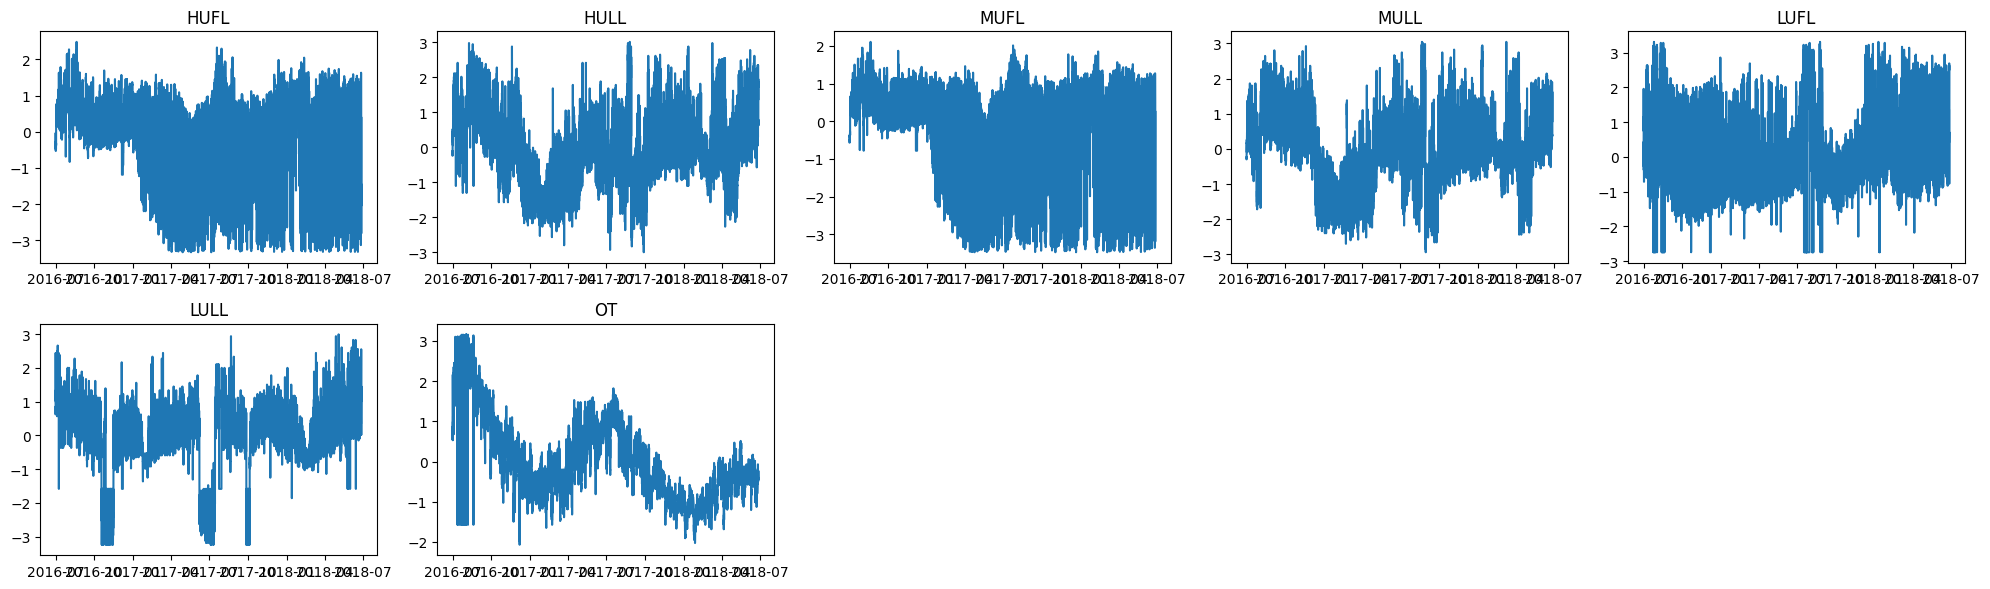

In [ ]:
def visualize_time_series(df, title="Time Series Visualization", n_cols=5, max_vars=10):
    """
    df: pd.DataFrame, index=Datetime, columns=features
    n_cols: ÏÑúÎ∏åÌîåÎ°Ø Ïª¨Îüº Ïàò
    max_vars: ÏµúÎåÄ Î™á Í∞ú Î≥ÄÏàòÎßå ÏãúÍ∞ÅÌôîÌï†ÏßÄ
    """
    num_vars = min(df.shape[1], max_vars)
    n_rows = (num_vars + n_cols - 1) // n_cols
    plt.figure(figsize=(4*n_cols, 3*n_rows))
    for i, col in enumerate(df.columns[:num_vars]):
        plt.subplot(n_rows, n_cols, i+1)
        plt.plot(df.index, df[col])
        plt.title(col)
        plt.tight_layout()
    plt.suptitle(title)
    plt.show()

# ÏÇ¨Ïö© ÏòàÏãú
visualize_time_series(df_processed, title="")


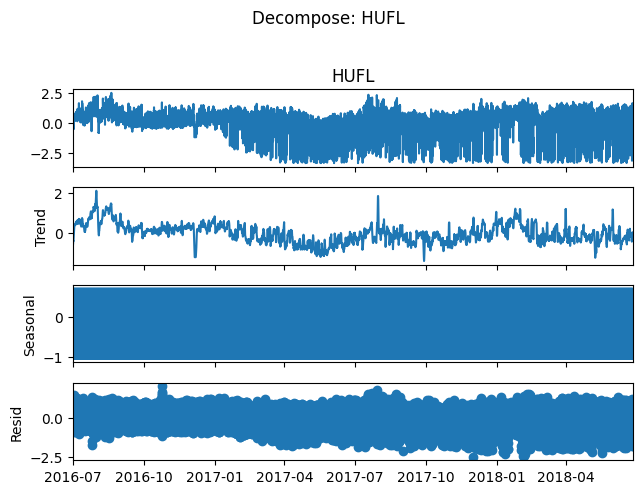

In [ ]:
def decompose_and_plot(df, col='OT', freq=24):
    """
    df: Ï†ÑÏ≤òÎ¶¨Îêú DataFrame
    col: Î∂ÑÌï¥Ìï† Ïª¨ÎüºÎ™Ö (ex: 'OT')
    freq: Í≥ÑÏ†àÏÑ± Ï£ºÍ∏∞ (Ïòà: ÏãúÍ∞ÑÎ≥ÑÏù¥Î©¥ 24, ÏùºÎ≥ÑÏù¥Î©¥ 7 Îì±)
    """
    if col not in df.columns:
        print(f"{col} Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§. Îã§Î•∏ Ïª¨ÎüºÎ™Ö ÏûÖÎ†• or col=df.columns[0]Î°ú Î≥ÄÍ≤Ω")
        col = df.columns[0]
    series = df[col]
    result = seasonal_decompose(series, model='additive', period=freq, extrapolate_trend='freq')
    result.plot()
    plt.suptitle(f"Decompose: {col}", y=1.02)
    plt.tight_layout()
    plt.show()

# ÏÇ¨Ïö© ÏòàÏãú
decompose_and_plot(df_processed, col="HUFL", freq=24)


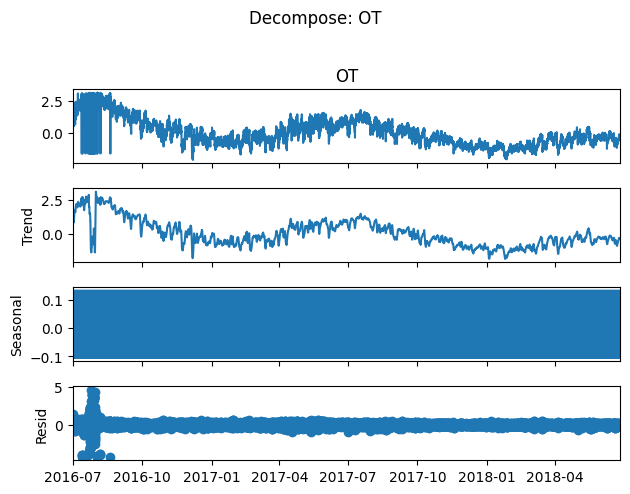

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def decompose_and_plot(df, col='OT', freq=24):
    """
    df: Ï†ÑÏ≤òÎ¶¨Îêú DataFrame
    col: Î∂ÑÌï¥Ìï† Ïª¨ÎüºÎ™Ö (ex: 'OT')
    freq: Í≥ÑÏ†àÏÑ± Ï£ºÍ∏∞ (Ïòà: ÏãúÍ∞ÑÎ≥ÑÏù¥Î©¥ 24, ÏùºÎ≥ÑÏù¥Î©¥ 7 Îì±)
    """
    if col not in df.columns:
        print(f"{col} Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§. Îã§Î•∏ Ïª¨ÎüºÎ™Ö ÏûÖÎ†• or col=df.columns[0]Î°ú Î≥ÄÍ≤Ω")
        col = df.columns[0]
    series = df[col]
    result = seasonal_decompose(series, model='additive', period=freq, extrapolate_trend='freq')
    result.plot()
    plt.suptitle(f"Decompose: {col}", y=1.02)
    plt.tight_layout()
    plt.show()

# ÏÇ¨Ïö© ÏòàÏãú
decompose_and_plot(df_processed, col="OT", freq=24)


In [ ]:
# PSM (Ïù¥ÏÉÅÏπò ÌÉêÏßÄ)
cfg = anomaly_cfg
df_train_proc, df_test_proc = analyze_and_preprocess(cfg)


1Ï∞® Î∂ÑÏÑù(PSM)

==== [PSM] Í∏∞Î≥∏ ÌÜµÍ≥Ñ Î∂ÑÏÑù ====
           feature_0      feature_1      feature_2      feature_3  \
count  132481.000000  132481.000000  132481.000000  132481.000000   
mean        0.835810       0.840205       0.634216       0.575081   
std         0.067326       0.039472       0.102920       0.049675   
min         0.486490       0.525682       0.421484       0.380874   
25%         0.789497       0.820488       0.580170       0.543702   
50%         0.837290       0.843873       0.603304       0.572077   
75%         0.880603       0.866423       0.625805       0.611127   
max         1.000000       0.909956       1.000000       0.676682   

           feature_4      feature_5      feature_6      feature_7  \
count  132279.000000  132232.000000  131918.000000  132434.000000   
mean        0.543310       0.511753       0.549268       0.537706   
std         0.089438       0.077771       0.064093       0.090120   
min         0.065106       0.110161       0.21

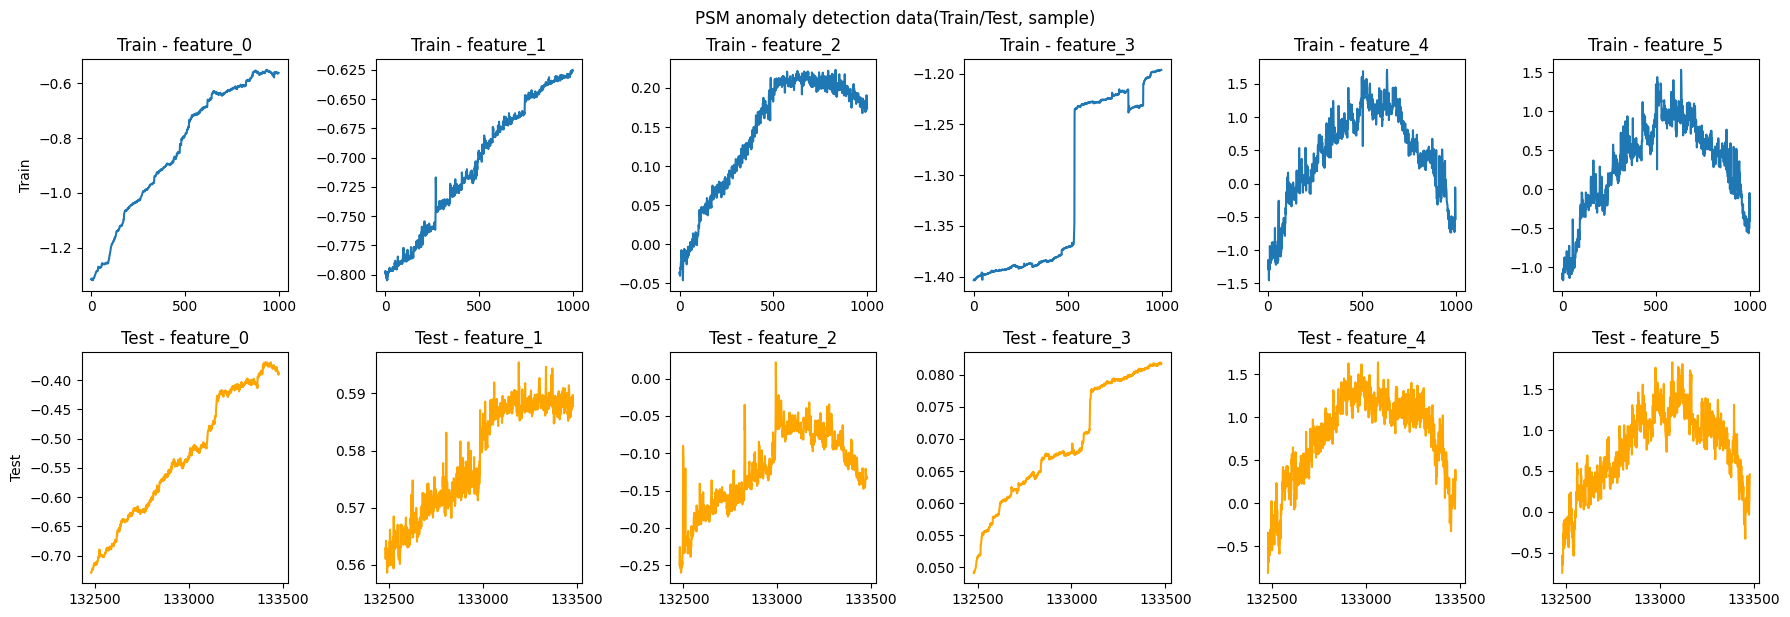

In [ ]:
def visualize_psm(df_train, df_test, max_vars=6, sample_len=1000):
    """
    PSM Ïù¥ÏÉÅÏπò ÌÉêÏßÄ Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞ÅÌôî
    - max_vars: ÏµúÎåÄ Î™á Í∞ú Î≥ÄÏàòÎßå ÏãúÍ∞ÅÌôî
    - sample_len: ÏïûÏóêÏÑú ÏñºÎßàÎßåÌÅºÎßå ÏãúÍ∞ÅÌôî (ÎÑàÎ¨¥ Í∏∏Î©¥ cut)
    """
    cols = df_train.columns[:max_vars]
    plt.figure(figsize=(18, 6))

    for i, col in enumerate(cols):
        plt.subplot(2, max_vars, i+1)
        plt.plot(df_train.index[:sample_len], df_train[col].values[:sample_len], label="Train")
        plt.title(f"Train - {col}")
        if i == 0: plt.ylabel("Train")
        plt.tight_layout()

        plt.subplot(2, max_vars, max_vars+i+1)
        plt.plot(df_test.index[:sample_len], df_test[col].values[:sample_len], label="Test", color="orange")
        plt.title(f"Test - {col}")
        if i == 0: plt.ylabel("Test")
        plt.tight_layout()
    plt.suptitle("PSM anomaly detection data(Train/Test, sample)", y=1.02)
    plt.show()

# ÏÇ¨Ïö© ÏòàÏãú
visualize_psm(df_train_proc, df_test_proc)


=== [Train] feature_0 ===


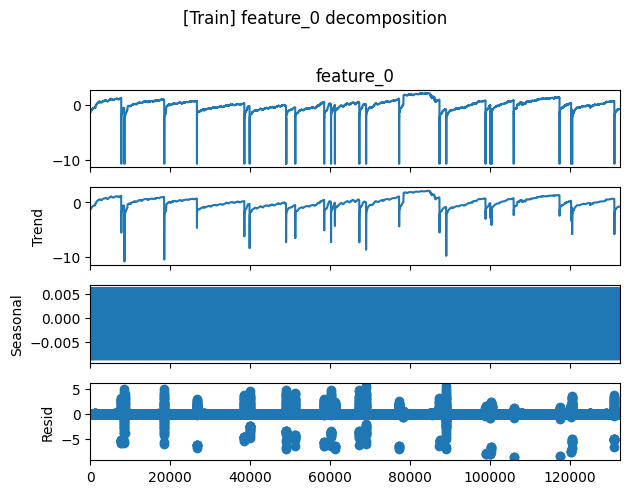

=== [Train] feature_1 ===


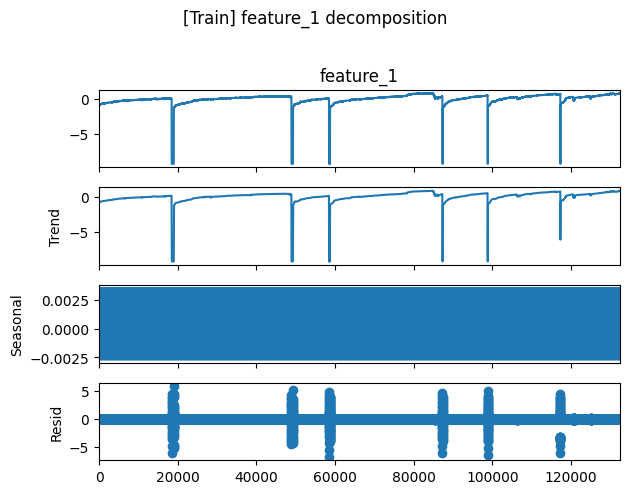

=== [Train] feature_2 ===


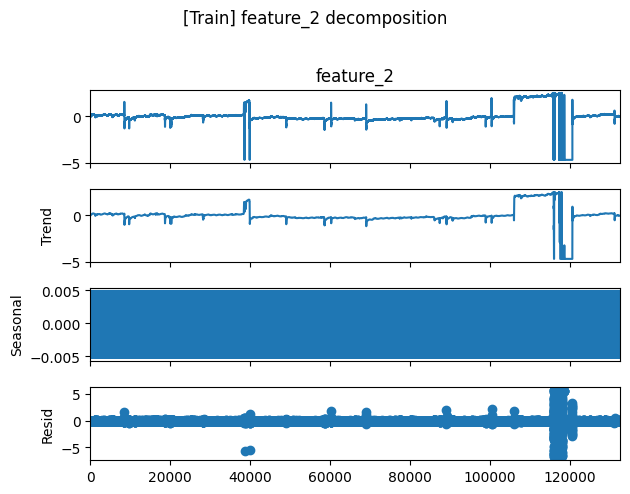

=== [Test] feature_0 ===


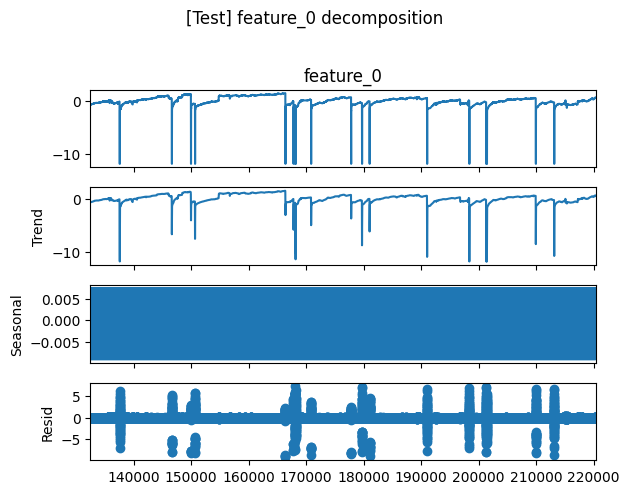

=== [Test] feature_1 ===


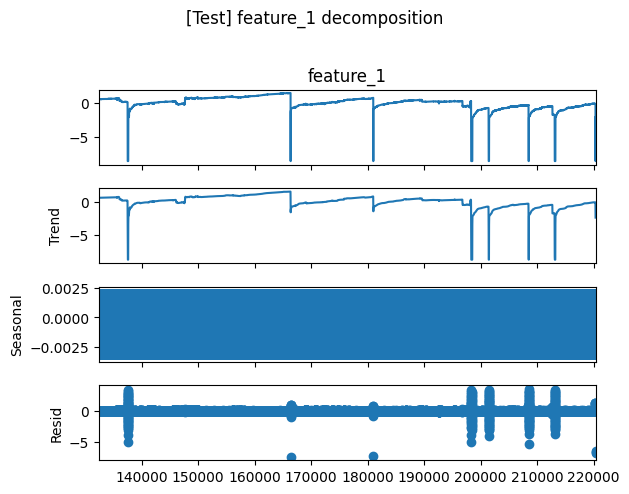

=== [Test] feature_2 ===


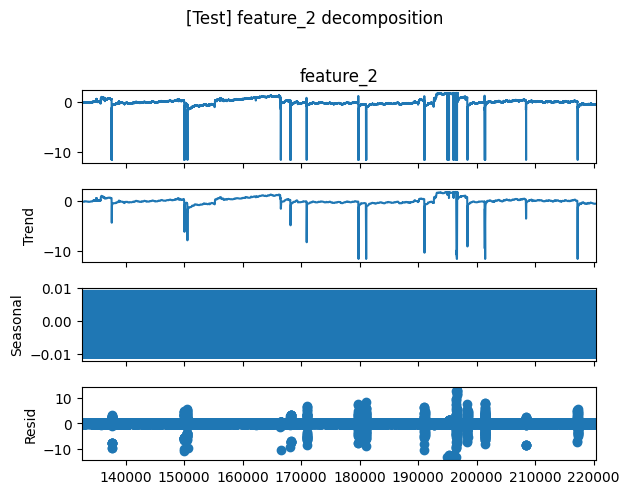

In [ ]:
def decompose_and_plot(df, col=None, freq=24, title_prefix=""):
    """
    df: ÏãúÍ≥ÑÏó¥ DataFrame (index=Datetime, columns=feature)
    col: Î∂ÑÌï¥Ìï† Ïª¨ÎüºÎ™Ö (ÏóÜÏúºÎ©¥ Ï≤´ Î≤àÏß∏ Ïª¨Îüº)
    freq: Í≥ÑÏ†àÏÑ± Ï£ºÍ∏∞ (Ïòà: 24=ÏùºÍ∞Ñ, 168=Ï£ºÍ∞Ñ)
    title_prefix: Í∑∏ÎûòÌîÑ Ï†úÎ™© Ï†ëÎëêÏÇ¨
    """
    if col is None or col not in df.columns:
        col = df.columns[0]  # ÏûêÎèô ÏÑ†ÌÉù
    series = df[col]
    result = seasonal_decompose(series, model='additive', period=freq, extrapolate_trend='freq')
    result.plot()
    plt.suptitle(f"{title_prefix}{col} decomposition", y=1.02)
    plt.tight_layout()
    plt.show()

# ÏòàÏãú: train/testÏóêÏÑú Ï£ºÏöî Î≥ÄÏàò Í∞ÅÍ∞Å Î∂ÑÌï¥
target_cols = df_train_proc.columns[:3]  # Ïïû 3Í∞ú Î≥ÄÏàòÎßå ÏòàÏãú (Î≥ÄÏàò ÎßéÏúºÎ©¥ Ï°∞Ï†ï)

for col in target_cols:
    print(f"=== [Train] {col} ===")
    decompose_and_plot(df_train_proc, col=col, freq=24, title_prefix="[Train] ")
for col in target_cols:
    print(f"=== [Test] {col} ===")
    decompose_and_plot(df_test_proc, col=col, freq=24, title_prefix="[Test] ")


In [42]:
# UEA Libras (Î∂ÑÎ•ò)
cfg = classification_cfg
(train_X_proc, train_y), (test_X_proc, test_y) = analyze_and_preprocess(cfg)


1Ï∞® Î∂ÑÏÑù(Train)

==== [Train (X)] Í∏∞Î≥∏ ÌÜµÍ≥Ñ Î∂ÑÏÑù ====
shape: (180, 2, 45)
Ï†ÑÏ≤¥ ÌèâÍ∑†: 0.5142851352469137
Ï†ÑÏ≤¥ ÌëúÏ§ÄÌé∏Ï∞®: 0.17931758625170993
Ï†ÑÏ≤¥ Í≤∞Ï∏°Ïπò Í∞úÏàò: 0

Ï†ïÏÉÅÏÑ±(ADF) ÌÖåÏä§Ìä∏ (Î≥ÄÏàò 3Í∞úÎßå):
var0: p-value=0.0000 Ï†ïÏÉÅ
var1: p-value=0.0036 Ï†ïÏÉÅ

[ÎùºÎ≤® Î∂ÑÌè¨]
1     12
2     12
3     12
4     12
5     12
6     12
7     12
8     12
9     12
10    12
11    12
12    12
13    12
14    12
15    12
Name: count, dtype: int64

Ï†ÑÏ≤òÎ¶¨ Ï§ë...
Ï†ÑÏ≤¥ Ïù¥ÏÉÅÏπò Í∞úÏàò (ndarray, Ï†ÑÏ≤òÎ¶¨ Ï†Ñ): 0

Ï†ÑÏ≤¥ Ïù¥ÏÉÅÏπò Í∞úÏàò (ndarray, Ï†ÑÏ≤òÎ¶¨ ÌõÑ): 0


==== [Train (X, Ï†ÑÏ≤òÎ¶¨)] Í∏∞Î≥∏ ÌÜµÍ≥Ñ Î∂ÑÏÑù ====
shape: (180, 2, 45)
Ï†ÑÏ≤¥ ÌèâÍ∑†: -4.631685981251023e-16
Ï†ÑÏ≤¥ ÌëúÏ§ÄÌé∏Ï∞®: 0.9999944233332366
Ï†ÑÏ≤¥ Í≤∞Ï∏°Ïπò Í∞úÏàò: 0

Ï†ïÏÉÅÏÑ±(ADF) ÌÖåÏä§Ìä∏ (Î≥ÄÏàò 3Í∞úÎßå):
var0: p-value=0.0000 Ï†ïÏÉÅ
var1: p-value=0.0036 Ï†ïÏÉÅ

1Ï∞® Î∂ÑÏÑù(Test)

==== [Test (X)] Í∏∞Î≥∏ ÌÜµÍ≥Ñ Î∂ÑÏÑù ====
shape: (180, 2, 45)
Ï†ÑÏ≤¥ ÌèâÍ∑†: 0.5092754867283951
Ï†ÑÏ≤¥ ÌëúÏ§ÄÌé∏

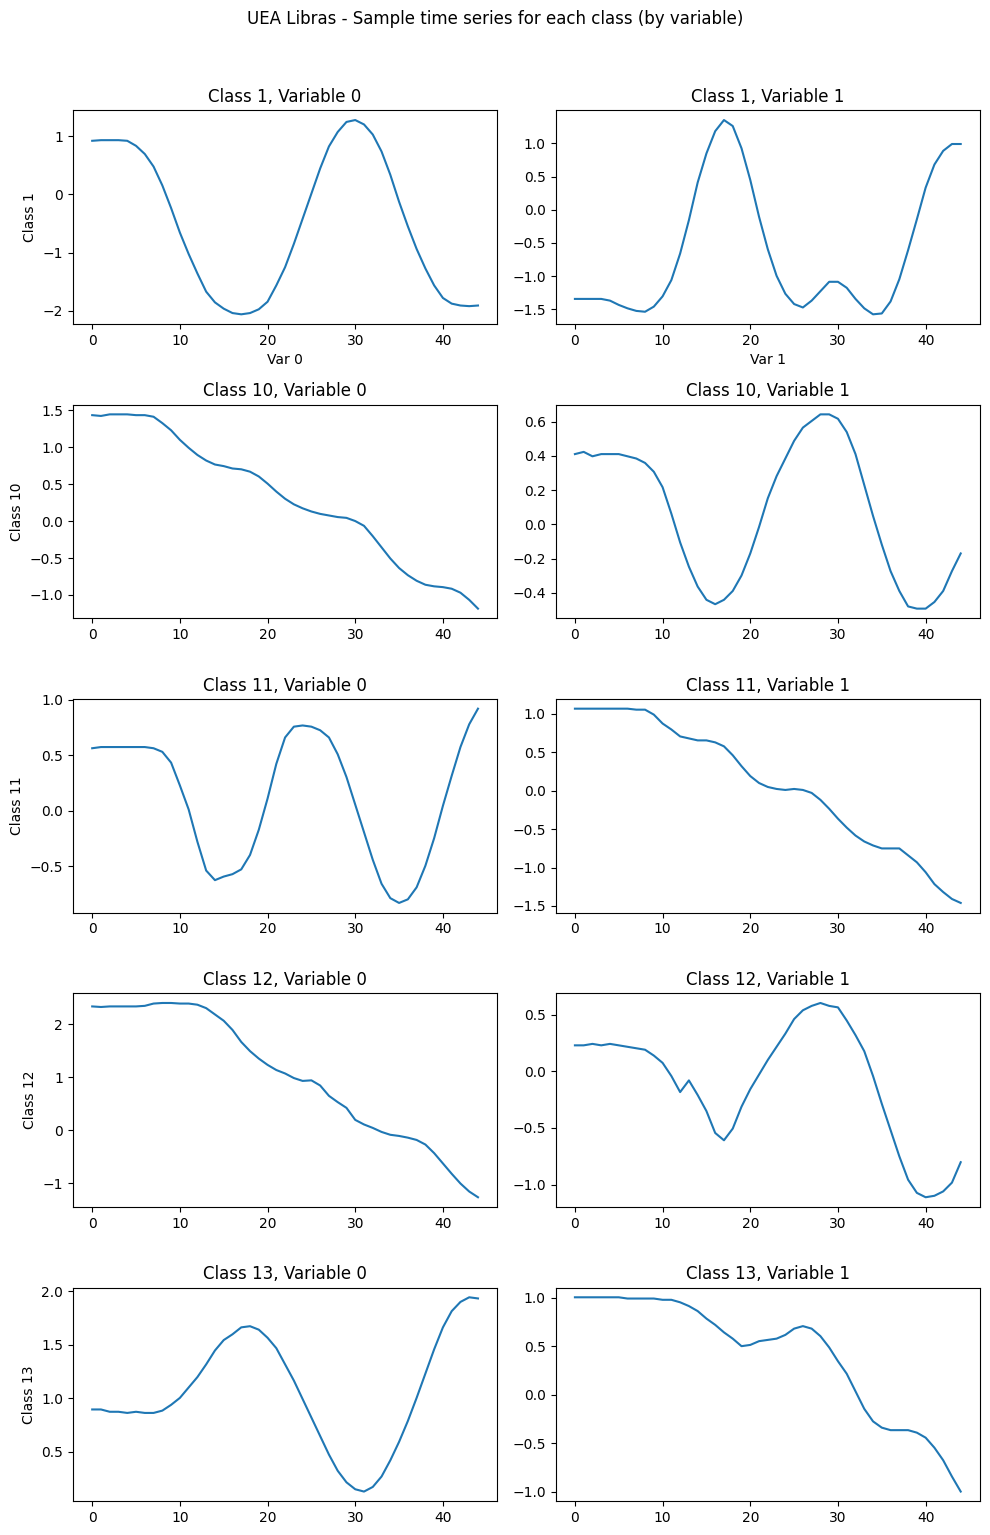

In [ ]:
def visualize_uea_multivariate(X, y, n_classes=5, max_vars=2):
    """
    X: (n_samples, n_vars, seq_len) np.ndarray ÎòêÎäî (n_samples, n_vars) DataFrame (cell=Series)
    y: (n_samples,) array-like (class labels)
    n_classes: Î™á Í∞ú ÌÅ¥ÎûòÏä§Îßå ÏãúÍ∞ÅÌôî (ÌÅ¥ÎûòÏä§Î≥Ñ Ï≤´ ÏÉòÌîå)
    max_vars: Î™á Í∞ú Î≥ÄÏàò(Ï±ÑÎÑê)ÍπåÏßÄ subplot (Í∞Å ÏãúÍ≥ÑÏó¥ Î≥ÄÏàòÎ≥Ñ)

    ÏòàÏãú: ÌÅ¥ÎûòÏä§Î≥Ñ(ÏµúÎåÄ n_classesÍ∞ú)Î°ú, Î≥ÄÏàòÎ≥Ñ(max_varsÍ∞ú) ÏãúÍ≥ÑÏó¥ÏùÑ Í∑∏Î¶∞Îã§.
    """
    # DataFrameÏù¥Î©¥ ndarrayÎ°ú Î≥ÄÌôò
    if isinstance(X, np.ndarray):
        arr = X
    elif isinstance(X, pd.DataFrame):
        n_samples, n_vars = X.shape
        seq_len = len(X.iloc[0,0])
        arr = np.empty((n_samples, n_vars, seq_len))
        for i in range(n_samples):
            for j in range(n_vars):
                arr[i, j, :] = X.iloc[i, j].values
    else:
        raise ValueError("ÏßÄÏõêÌïòÏßÄ ÏïäÎäî X ÌÉÄÏûÖÏûÖÎãàÎã§.")

    classes = np.unique(y)
    n_plots = min(n_classes, len(classes))
    n_vars = min(arr.shape[1], max_vars)
    plt.figure(figsize=(5*n_vars, 3*n_plots))
    for i, cls in enumerate(classes[:n_plots]):
        idx = np.where(y == cls)[0][0]  # Ìï¥Îãπ ÌÅ¥ÎûòÏä§Ïùò Ï≤´ ÏÉòÌîå index
        for j in range(n_vars):
            plt.subplot(n_plots, n_vars, i*n_vars + j + 1)
            plt.plot(arr[idx, j, :])
            plt.title(f"Class {cls}, Variable {j}")
            if j == 0: plt.ylabel(f"Class {cls}")
            if i == 0: plt.xlabel(f"Var {j}")
    plt.suptitle("UEA Libras - Sample time series for each class (by variable)", y=1.02)
    plt.tight_layout()
    plt.show()

# ÏÇ¨Ïö© ÏòàÏãú
visualize_uea_multivariate(train_X_proc, train_y, n_classes=5, max_vars=2)


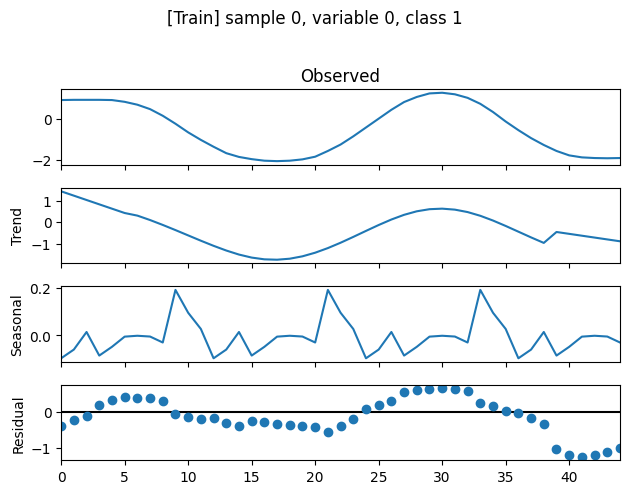

In [ ]:
def decompose_sample_time_series(X, y, sample_idx=0, var_idx=0, freq=12, title_prefix=""):
    """
    X: (n_samples, n_vars, seq_len) ndarray or DataFrame
    y: (n_samples,)
    sample_idx: Î∂ÑÌï¥Ìï† ÏÉòÌîå Ïù∏Îç±Ïä§
    var_idx: Î∂ÑÌï¥Ìï† Î≥ÄÏàò(Ï±ÑÎÑê) Ïù∏Îç±Ïä§
    freq: Í≥ÑÏ†àÏÑ± Ï£ºÍ∏∞ (Ïòà: 12=1ÎÖÑ/12Í∞úÏõî, Îç∞Ïù¥ÌÑ∞ ÏÉÅÌô© ÎßûÍ≤å)
    """
    # DataFrame ÌòïÌÉúÎùºÎ©¥ ndarrayÎ°ú Î≥ÄÌôò
    if isinstance(X, pd.DataFrame):
        series = X.iloc[sample_idx, var_idx].values
    elif isinstance(X, np.ndarray):
        series = X[sample_idx, var_idx, :]
    else:
        raise ValueError("ÏßÄÏõêÌïòÏßÄ ÏïäÎäî X ÌÉÄÏûÖÏûÖÎãàÎã§.")

    # ÏãúÍ≥ÑÏó¥ Î∂ÑÌï¥
    result = seasonal_decompose(series, model='additive', period=freq, extrapolate_trend='freq')
    result.plot()
    plt.suptitle(f"{title_prefix}sample {sample_idx}, variable {var_idx}, class {y[sample_idx]}", y=1.02)
    plt.tight_layout()
    plt.show()

# ÏòàÏãú: ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï≤´ Î≤àÏß∏ ÏÉòÌîå, Ï≤´ Î≤àÏß∏ Î≥ÄÏàò, freq=12Î°ú Î∂ÑÌï¥
decompose_sample_time_series(train_X_proc, train_y, sample_idx=0, var_idx=0, freq=12, title_prefix="[Train] ")

###Awkward array Î∞è numba ÏÇ¨Ïö© Îç∞Î™®


ETTh1 Îç∞Ïù¥ÌÑ∞Î•º ÌôúÏö©Ìïú Awkward Array & Numba ÏáºÏºÄÏù¥Ïä§
[INFO] ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ./dataset/ETT-small/ETTh1.csvÏóêÏÑú Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìúÌñàÏäµÎãàÎã§.

Îç∞Ïù¥ÌÑ∞ shape: (17420, 7)
Ïª¨Îüº: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

1. Ïù¥ÏÉÅÏπò ÌÉêÏßÄ ÏÑ±Îä• ÎπÑÍµê (Python vs Numba)
Python Î≤ÑÏ†Ñ: 0.0071Ï¥à
Numba Î≤ÑÏ†Ñ: 1.9245Ï¥à
ÏÜçÎèÑ Ìñ•ÏÉÅ: 0.0Î∞∞ Îπ®ÎùºÏßê!

Í∞Å Ïª¨ÎüºÎ≥Ñ Ïù¥ÏÉÅÏπò Í∞úÏàò:
  HUFL: 297Í∞ú
  HULL: 41Í∞ú
  MUFL: 366Í∞ú
  MULL: 61Í∞ú
  LUFL: 219Í∞ú
  LULL: 323Í∞ú
  OT: 159Í∞ú

2. Awkward ArrayÎ°ú Í∞ÄÎ≥Ä Í∏∏Ïù¥ ÏãúÍ≥ÑÏó¥ Ï≤òÎ¶¨
ÏÉùÏÑ±Îêú ÏãúÌÄÄÏä§ Í∞úÏàò: 719
ÏãúÌÄÄÏä§ Í∏∏Ïù¥ Î∂ÑÌè¨:
  ÏµúÏÜå: 24, ÏµúÎåÄ: 167, ÌèâÍ∑†: 96.6

Í∞Å ÌîºÏ≤òÎ≥Ñ ÌèâÍ∑†Í∞í (Ï≤òÏùå 5Í∞ú ÏãúÌÄÄÏä§):
  ÏãúÌÄÄÏä§ 0: [9.200674632238963, 4.5311904852352445, 5.848079351205675] ... (Ï≤òÏùå 3Í∞ú ÌîºÏ≤òÎßå ÌëúÏãú)
  ÏãúÌÄÄÏä§ 1: [10.225965540984582, 4.965758619637325, 6.8641120524242005] ... (Ï≤òÏùå 3Í∞ú ÌîºÏ≤òÎßå ÌëúÏãú)
  ÏãúÌÄÄÏä§ 2: [10.468236923217773, 5.219131582661679, 7.03131575

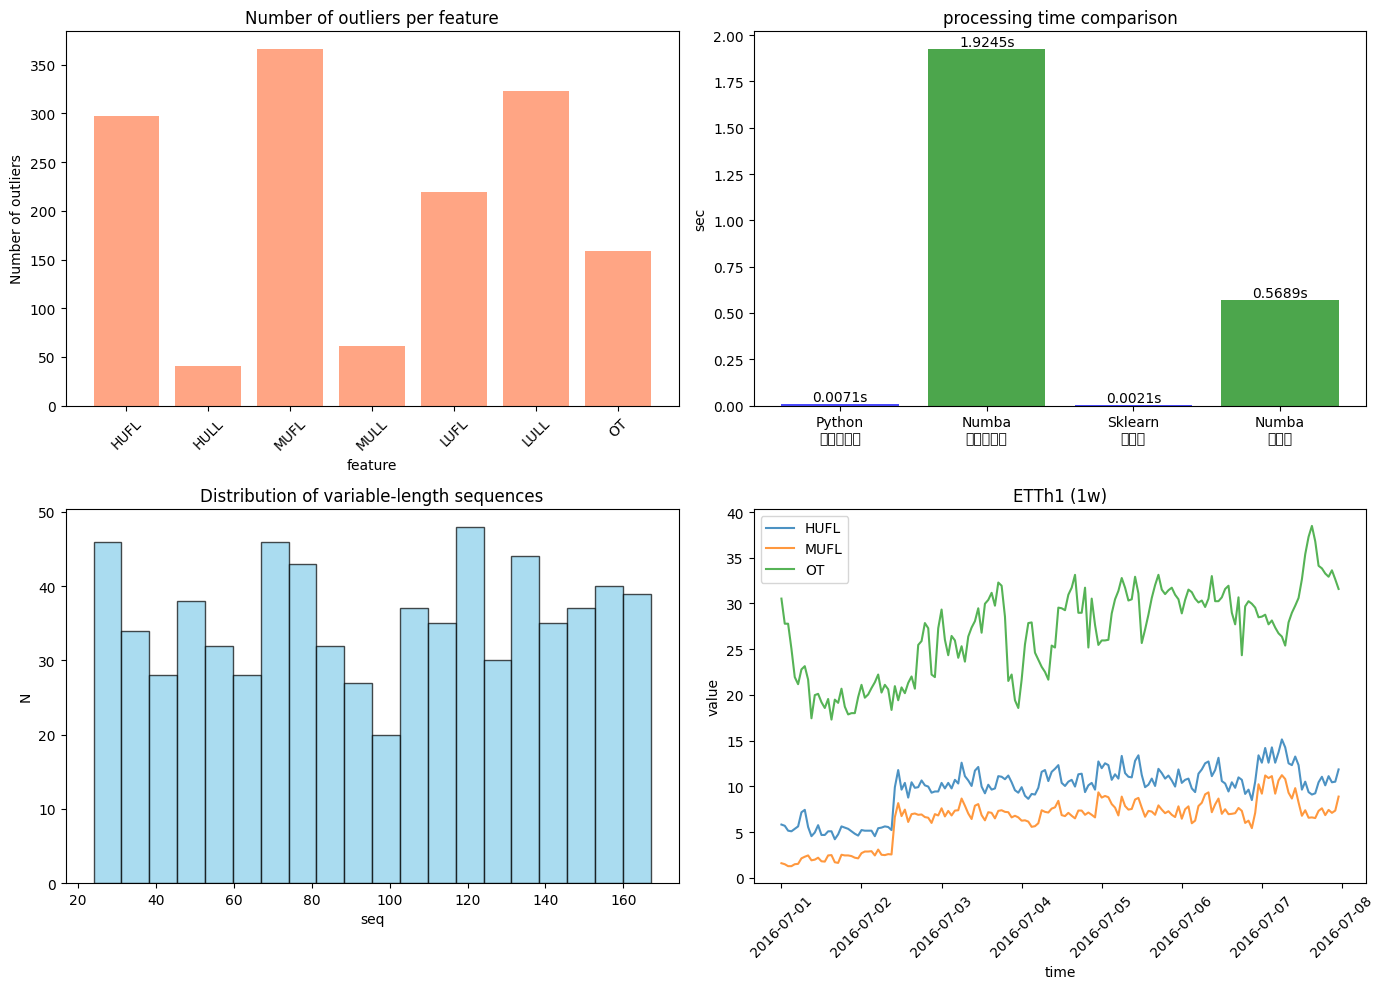

In [ ]:
# Ï†úÍ≥µÎêú Ï†ÑÏ≤òÎ¶¨ Ìï®ÏàòÎì§ (ÏàòÏ†ïÎê®)
def load_dataset(cfg):
    # ÌïòÎìúÏΩîÎî©ÏúºÎ°ú ÏßÅÏ†ë Í≤ΩÎ°ú ÏßÄÏ†ï
    file_path = './dataset/ETT-small/ETTh1.csv'
    try:
        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
        print(f"[INFO] ÏÑ±Í≥µÏ†ÅÏúºÎ°ú {file_path}ÏóêÏÑú Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìúÌñàÏäµÎãàÎã§.")
        return df
    except FileNotFoundError:
        print(f"[WARNING] ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {file_path}")


# 1. NumbaÎ°ú Í∞ÄÏÜçÌôîÎêú Ïù¥ÏÉÅÏπò ÌÉêÏßÄ
@njit(parallel=True)
def fast_outlier_detection(data, threshold=3):
    """NumbaÎ°ú Í∞ÄÏÜçÌôîÎêú Ïù¥ÏÉÅÏπò ÌÉêÏßÄ"""
    n_samples, n_features = data.shape
    outlier_mask = np.zeros((n_samples, n_features), dtype=np.bool_)
    outlier_counts = np.zeros(n_features)

    for j in prange(n_features):
        col_data = data[:, j]
        mean = np.mean(col_data)
        std = np.std(col_data)

        for i in range(n_samples):
            if abs(col_data[i] - mean) > threshold * std:
                outlier_mask[i, j] = True
                outlier_counts[j] += 1

    return outlier_mask, outlier_counts

# ÏùºÎ∞ò Python Î≤ÑÏ†Ñ
def slow_outlier_detection(df, threshold=3):
    """ÏùºÎ∞ò Python Ïù¥ÏÉÅÏπò ÌÉêÏßÄ (ÎπÑÍµêÏö©)"""
    outlier_counts = {}
    for col in df.columns:
        col_z = (df[col] - df[col].mean()) / (df[col].std() + 1e-6)
        outlier_counts[col] = (col_z.abs() > threshold).sum()
    return outlier_counts

# 2. Awkward ArrayÎ°ú Í∞ÄÎ≥Ä Í∏∏Ïù¥ ÏãúÍ≥ÑÏó¥ Ï≤òÎ¶¨
def create_variable_length_sequences(df, min_len=24, max_len=168):
    """Í∞ÄÎ≥Ä Í∏∏Ïù¥ ÏãúÌÄÄÏä§ ÏÉùÏÑ± (Ïòà: 1Ïùº~7Ïùº Í∏∏Ïù¥)"""
    sequences = []
    labels = []

    for i in range(0, len(df) - max_len, 24):  # 24ÏãúÍ∞Ñ Îã®ÏúÑÎ°ú Ïù¥Îèô
        # ÎûúÎç§Ìïú Í∏∏Ïù¥Ïùò ÏãúÌÄÄÏä§ ÏÉùÏÑ±
        seq_len = np.random.randint(min_len, max_len)
        seq = df.iloc[i:i+seq_len].values
        sequences.append(seq)
        # Îã§Ïùå ÏãúÍ∞ÑÏùò OT Í∞íÏùÑ ÏòàÏ∏° ÌÉÄÍ≤üÏúºÎ°ú
        labels.append(df.iloc[i+seq_len]['OT'] if i+seq_len < len(df) else 0)

    return sequences, labels

# 3. Ï†ÑÏ≤òÎ¶¨ ÏÑ±Îä• ÎπÑÍµê Ìï®Ïàò
@njit
def fast_standardize(data):
    """NumbaÎ°ú Í∞ÄÏÜçÌôîÎêú ÌëúÏ§ÄÌôî"""
    n_samples, n_features = data.shape
    result = np.zeros_like(data)

    for j in range(n_features):
        col = data[:, j]
        mean = np.mean(col)
        std = np.std(col)
        for i in range(n_samples):
            result[i, j] = (col[i] - mean) / (std + 1e-6)

    return result

# Î©îÏù∏ Ïã§Ìñâ ÏΩîÎìú
print("="*60)
print("ETTh1 Îç∞Ïù¥ÌÑ∞Î•º ÌôúÏö©Ìïú Awkward Array & Numba ÏáºÏºÄÏù¥Ïä§")
print("="*60)

# ÏßÅÏ†ë Îç∞Ïù¥ÌÑ∞ Î°úÎìú
df = load_dataset(None)  # cfg Îß§Í∞úÎ≥ÄÏàòÎäî ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏúºÎØÄÎ°ú None Ï†ÑÎã¨

print(f"\nÎç∞Ïù¥ÌÑ∞ shape: {df.shape}")
print(f"Ïª¨Îüº: {list(df.columns)}")

# 1. Numba ÏÑ±Îä• ÎπÑÍµê
print("\n" + "="*60)
print("1. Ïù¥ÏÉÅÏπò ÌÉêÏßÄ ÏÑ±Îä• ÎπÑÍµê (Python vs Numba)")
print("="*60)

# Python Î≤ÑÏ†Ñ
start = time.time()
outliers_py = slow_outlier_detection(df, threshold=3)
time_py = time.time() - start

# Numba Î≤ÑÏ†Ñ
data_array = df.values
fast_outlier_detection(data_array[:100], 3)  # ÏõåÎ∞çÏóÖ
start = time.time()
outlier_mask, outliers_nb = fast_outlier_detection(data_array, threshold=3)
time_nb = time.time() - start

print(f"Python Î≤ÑÏ†Ñ: {time_py:.4f}Ï¥à")
print(f"Numba Î≤ÑÏ†Ñ: {time_nb:.4f}Ï¥à")
print(f"ÏÜçÎèÑ Ìñ•ÏÉÅ: {time_py/time_nb:.1f}Î∞∞ Îπ®ÎùºÏßê!")

print("\nÍ∞Å Ïª¨ÎüºÎ≥Ñ Ïù¥ÏÉÅÏπò Í∞úÏàò:")
for i, col in enumerate(df.columns):
    print(f"  {col}: {int(outliers_nb[i])}Í∞ú")

# 2. Awkward ArrayÎ°ú Í∞ÄÎ≥Ä Í∏∏Ïù¥ ÏãúÌÄÄÏä§ Ï≤òÎ¶¨
print("\n" + "="*60)
print("2. Awkward ArrayÎ°ú Í∞ÄÎ≥Ä Í∏∏Ïù¥ ÏãúÍ≥ÑÏó¥ Ï≤òÎ¶¨")
print("="*60)

sequences, labels = create_variable_length_sequences(df)
ak_sequences = ak.Array(sequences)

print(f"ÏÉùÏÑ±Îêú ÏãúÌÄÄÏä§ Í∞úÏàò: {len(ak_sequences)}")
print(f"ÏãúÌÄÄÏä§ Í∏∏Ïù¥ Î∂ÑÌè¨:")
lengths = ak.num(ak_sequences, axis=1)
print(f"  ÏµúÏÜå: {ak.min(lengths)}, ÏµúÎåÄ: {ak.max(lengths)}, ÌèâÍ∑†: {ak.mean(lengths):.1f}")

# Í∞Å ÏãúÌÄÄÏä§Ïùò ÌÜµÍ≥Ñ Í≥ÑÏÇ∞ (Í∞ÄÎ≥Ä Í∏∏Ïù¥ÏóêÎèÑ Ï†ÅÏö© Í∞ÄÎä•)
seq_means = ak.mean(ak_sequences, axis=1)
seq_stds = ak.std(ak_sequences, axis=1)

print(f"\nÍ∞Å ÌîºÏ≤òÎ≥Ñ ÌèâÍ∑†Í∞í (Ï≤òÏùå 5Í∞ú ÏãúÌÄÄÏä§):")
for i in range(min(5, len(seq_means))):
    print(f"  ÏãúÌÄÄÏä§ {i}: {seq_means[i][:3].to_list()} ... (Ï≤òÏùå 3Í∞ú ÌîºÏ≤òÎßå ÌëúÏãú)")

# 3. Ï†ÑÏ≤òÎ¶¨ ÏÜçÎèÑ ÎπÑÍµê
print("\n" + "="*60)
print("3. Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî ÏÑ±Îä• ÎπÑÍµê")
print("="*60)

# Scikit-learn StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
start = time.time()
scaled_sklearn = scaler.fit_transform(data_array)
time_sklearn = time.time() - start

# Numba Î≤ÑÏ†Ñ
fast_standardize(data_array[:100])  # ÏõåÎ∞çÏóÖ
start = time.time()
scaled_numba = fast_standardize(data_array)
time_numba = time.time() - start

print(f"Scikit-learn StandardScaler: {time_sklearn:.4f}Ï¥à")
print(f"Numba Î≤ÑÏ†Ñ: {time_numba:.4f}Ï¥à")
print(f"ÏÜçÎèÑ Ìñ•ÏÉÅ: {time_sklearn/time_numba:.1f}Î∞∞ Îπ®ÎùºÏßê!")

# 4. ÏãúÍ∞ÅÌôî
print("\n" + "="*60)
print("4. Í≤∞Í≥º ÏãúÍ∞ÅÌôî")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 4-1. Ïù¥ÏÉÅÏπò Î∂ÑÌè¨
ax = axes[0, 0]
ax.bar(df.columns, outliers_nb, color='coral', alpha=0.7)
ax.set_title('Number of outliers per feature')
ax.set_xlabel('feature')
ax.set_ylabel('Number of outliers')
ax.tick_params(axis='x', rotation=45)

# 4-2. ÏÑ±Îä• ÎπÑÍµê
ax = axes[0, 1]
methods = ['Python\nÏù¥ÏÉÅÏπòÌÉêÏßÄ', 'Numba\nÏù¥ÏÉÅÏπòÌÉêÏßÄ', 'Sklearn\nÏ†ïÍ∑úÌôî', 'Numba\nÏ†ïÍ∑úÌôî']
times = [time_py, time_nb, time_sklearn, time_numba]
colors = ['blue', 'green', 'blue', 'green']
bars = ax.bar(methods, times, color=colors, alpha=0.7)
ax.set_title('processing time comparison')
ax.set_ylabel('sec')
for bar, time_val in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{time_val:.4f}s', ha='center', va='bottom')

# 4-3. ÏãúÌÄÄÏä§ Í∏∏Ïù¥ Î∂ÑÌè¨
ax = axes[1, 0]
lengths_list = lengths.to_list()
ax.hist(lengths_list, bins=20, color='skyblue', alpha=0.7, edgecolor='black')
ax.set_title('Distribution of variable-length sequences')
ax.set_xlabel('seq')
ax.set_ylabel('N')

# 4-4. ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå
ax = axes[1, 1]
sample_data = df.iloc[:168]  # 1Ï£ºÏùº Îç∞Ïù¥ÌÑ∞
for col in ['HUFL', 'MUFL', 'OT']:
    ax.plot(sample_data.index, sample_data[col], label=col, alpha=0.8)
ax.set_title('ETTh1 (1w)')
ax.set_xlabel('time')
ax.set_ylabel('value')
ax.legend()
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# 1-1~3 Ìï≠Î™©Ïùò EDA ÏΩîÎìú ÏûëÏÑ±
################### EDIT YOUR CODE #########################

############################################################

In [ ]:
# def create_dataloader_default(
#         task_name: str,
#         data_name: str,
#         sub_data_name: str,
#         data_info: dict,
#         train_setting: dict,
#         scaler: str,
#         window_size: int,
#         label_len: int,
#         pred_len: int,
#         model_type: str,
#         split_rate: list,
#         timeenc: int,
#         freq: str
#         ):
#     #################### EDIT YOUR CODE #########################

#     #############################################################

In [32]:
# ----- 1. ÏòàÏ∏°/Ïù¥ÏÉÅÏπò (window Í∏∞Î∞ò Dataset) -----
class TimeSeriesDataset(Dataset):
    def __init__(self, data_array, window_size, label_len, pred_len):
        self.data = data_array
        self.window_size = window_size
        self.label_len = label_len
        self.pred_len = pred_len
        self.total_window = window_size + pred_len

    def __len__(self):
        return max(0, len(self.data) - self.total_window + 1)

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.window_size]
        y = self.data[idx + self.window_size : idx + self.window_size + self.pred_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# ----- 2. UEA Îì± Î∂ÑÎ•ò Îç∞Ïù¥ÌÑ∞Ïö© Dataset -----
class SequenceClassificationDataset(Dataset):
    def __init__(self, X, y):
        # X: (n_samples, n_vars, seq_len) ndarray or DataFrame
        if isinstance(X, pd.DataFrame):
            n_samples, n_vars = X.shape
            seq_len = len(X.iloc[0,0])
            arr = np.empty((n_samples, n_vars, seq_len))
            for i in range(n_samples):
                for j in range(n_vars):
                    arr[i, j, :] = X.iloc[i, j].values
            self.X = arr
        elif isinstance(X, np.ndarray):
            self.X = X
        else:
            raise ValueError("ÏßÄÏõêÌïòÏßÄ ÏïäÎäî X ÌÉÄÏûÖÏûÖÎãàÎã§.")
        self.y = np.array(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # (n_vars, seq_len)
        y = self.y[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# ----- 3. Î©îÏù∏ Î°úÎçî ÏÉùÏÑ± Ìï®Ïàò (task Î∂ÑÍ∏∞, argument ÏµúÎåÄ Î∞òÏòÅ) -----
def create_dataloader_default(
    task_name: str,
    data_name: str,
    sub_data_name: str,
    data_info: dict,
    train_setting: dict,
    scaler: str,
    window_size: int,
    label_len: int,
    pred_len: int,
    model_type: str,
    split_rate: list,
    timeenc: int,
    freq: str,
    dataframe=None,
    X_train=None, y_train=None, X_test=None, y_test=None
):
    """
    task_name: "long_term_forecast", "anomaly_detection", "classification"
    dataframe: ÏòàÏ∏°/Ïù¥ÏÉÅÏπòÏö© DataFrame
    X_train, y_train, X_test, y_test: Î∂ÑÎ•òÏö© UEA ndarray/DataFrame
    """
    if task_name in ["long_term_forecast", "anomaly_detection"]:
        df = dataframe.copy()
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'])
            # ÏãúÍ∞Ñ Î∂àÏó∞ÏÜç Íµ¨Í∞Ñ ÏÇ≠Ï†ú (freq gap)
            if freq:
                try:
                    expected_delta = pd.to_timedelta(freq)
                except:
                    expected_delta = pd.Timedelta(1, unit=freq)
                diffs = df['date'].diff().fillna(expected_delta)
                valid = (diffs == expected_delta)
                df = df[valid.values].reset_index(drop=True)
        features = [col for col in df.columns if col != 'date']
        values = df[features].values
        n_total = len(values)
        train_end = int(n_total * split_rate[0])
        val_end = int(n_total * (split_rate[0] + split_rate[1]))
        train_vals = values[:train_end]
        val_vals = values[train_end:val_end]
        test_vals = values[val_end:]

        # Ïä§ÏºÄÏùºÎßÅ
        scaler_obj = None
        if scaler == 'standard':
            scaler_obj = StandardScaler()
        elif scaler == 'minmax':
            scaler_obj = MinMaxScaler()
        if scaler_obj is not None:
            scaler_obj.fit(train_vals)
            train_vals = scaler_obj.transform(train_vals)
            val_vals = scaler_obj.transform(val_vals)
            test_vals = scaler_obj.transform(test_vals)

        # Dataset & DataLoader
        train_dataset = TimeSeriesDataset(train_vals, window_size, label_len, pred_len)
        val_dataset = TimeSeriesDataset(val_vals, window_size, label_len, pred_len)
        test_dataset = TimeSeriesDataset(test_vals, window_size, label_len, pred_len)

        train_loader = DataLoader(
            train_dataset,
            batch_size=train_setting.get('batch_size', 64),
            shuffle=train_setting.get('shuffle', False),
            num_workers=train_setting.get('num_workers', 0),
            pin_memory=train_setting.get('pin_memory', True)
        )
        valid_loader = DataLoader(
            val_dataset,
            batch_size=train_setting.get('batch_size', 64),
            shuffle=False,
            num_workers=train_setting.get('num_workers', 0),
            pin_memory=train_setting.get('pin_memory', True)
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=train_setting.get('batch_size', 64),
            shuffle=False,
            num_workers=train_setting.get('num_workers', 0),
            pin_memory=train_setting.get('pin_memory', True)
        )

        information_dict = {
            'features': features,
            'scaler': scaler_obj,
            'window_size': window_size,
            'label_len': label_len,
            'pred_len': pred_len,
            'dataset_lengths': {
                'train': len(train_dataset),
                'val': len(val_dataset),
                'test': len(test_dataset)
            },
            'task_name': task_name,
            'data_name': data_name,
            'sub_data_name': sub_data_name,
            'model_type': model_type,
            'timeenc': timeenc,
            'freq': freq
        }
        return information_dict, train_loader, valid_loader, test_loader

    elif task_name == "classification":
        # UEA Î∂ÑÎ•ò Îç∞Ïù¥ÌÑ∞ (train/test Î∂ÑÎ¶¨)
        # Í∞ôÏùÄ ÏãúÍ≥ÑÏó¥ Í∏∏Ïù¥Îßå ÏÇ¨Ïö©ÌïòÎäî Î∂ÄÎ∂ÑÏùÄ analyze_and_preprocess Îã®Í≥ÑÏóêÏÑú ÌïÑÌÑ∞ÎßÅ ÌïÑÏöî
        train_dataset = SequenceClassificationDataset(X_train, y_train)
        test_dataset  = SequenceClassificationDataset(X_test, y_test)
        train_loader = DataLoader(
            train_dataset,
            batch_size=train_setting.get('batch_size', 64),
            shuffle=train_setting.get('shuffle', True),
            num_workers=train_setting.get('num_workers', 0),
            pin_memory=train_setting.get('pin_memory', True)
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=train_setting.get('batch_size', 64),
            shuffle=False,
            num_workers=train_setting.get('num_workers', 0),
            pin_memory=train_setting.get('pin_memory', True)
        )
        information_dict = {
            'n_vars': train_dataset.X.shape[1],
            'seq_len': train_dataset.X.shape[2],
            'num_classes': len(np.unique(y_train)),
            'dataset_lengths': {
                'train': len(train_dataset),
                'test': len(test_dataset)
            },
            'task_name': task_name,
            'data_name': data_name,
            'sub_data_name': sub_data_name,
            'model_type': model_type,
            'timeenc': timeenc,
            'freq': freq
        }
        return information_dict, train_loader, test_loader
    else:
        raise ValueError(f"ÏßÄÏõêÌïòÏßÄ ÏïäÎäî task_name: {task_name}")


In [33]:
information_dict, trn_dataloader, valid_dataloader, test_dataloader = create_dataloader_default(
    task_name="long_term_forecast",
    data_name="ETTh1",
    sub_data_name=None,
    data_info=cfg.DATAINFO,
    train_setting=cfg.TRAIN,
    scaler=cfg.DATASET.scaler,
    window_size=cfg.DATASET.window_size,
    label_len=cfg.DATASET.label_len,
    pred_len=cfg.DATASET.pred_len,
    model_type=cfg.DATASET.model_type,
    split_rate=cfg.DATASET.split_rate,
    timeenc=cfg.DATASET.timeenc,
    freq=cfg.DATASET.freq,
    dataframe=df_processed
)


In [34]:
print(trn_dataloader.dataset.data.shape)
print(valid_dataloader.dataset.data.shape)
print(test_dataloader.dataset.data.shape)

(12194, 7)
(1741, 7)
(3485, 7)


In [35]:
# Update dataset information to cfg

def update_information(model_name, cfg, information_dict):
    dataset_attrs = ['window_size', 'label_len', 'pred_len', 'taskname',
                     'pretrain', 'timeenc', 'freq', 'embed_type']

    for attr in dataset_attrs:
        setattr(cfg.MODELSETTING, attr, getattr(cfg.DATASET, attr))

    cfg.MODELSETTING.batch_size = cfg.TRAIN.batch_size

    model_attrs = ['enc_in', 'c_out']
    for attr in model_attrs:
        if attr in information_dict:
            setattr(cfg.MODELSETTING, attr, information_dict[attr])


update_information(model_name        = cfg.MODEL.modelname,
                    cfg              = cfg,
                    information_dict = information_dict)

## 2. Î™®Îç∏ Íµ¨Ï∂ï

    2-1) Î™®Îç∏ÏùÄ Head Î∂ÄÎ∂ÑÏùÑ ÏàòÏ†ïÌïòÏó¨ Í∞Å TaskÏóê Ïù¥Ïö© Í∞ÄÎä•Ìïú Î™®Îç∏ ÌòïÌÉú ÏûÑÏùòÎ°ú Íµ¨ÏÑ±ÌïòÏó¨ ÏÇ¨Ïö©. Í∏∞Ï°¥ Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïòÎäî Í≤ΩÏö∞ Ïû¨ÌòÑÌïòÏó¨ ÏÇ¨Ïö©Ìï† Í≤É
    2-2) Î™®Îç∏Ïùò ÏûÖÎ†•Î∂ÄÌÑ∞ Ï∂úÎ†•ÍπåÏßÄ Î™®Îì† Î≥ÄÌôî Ï§ë Î™®Îç∏Ïùò Ï∞®Ïõê ÌòïÌÉú Î≥ÄÌôî Í∏∞Ïû¨

In [ ]:
################### EDIT YOUR CODE #########################
# EX)
# class YOUR_MODEL(nn.Module):
#     def __init__(self, configs, individual=False):
#         super(YOUR_MODEL, self).__init__()
#         self.task_name = configs.taskname
#         self.model = nn.Linear(96, 96)
#     def forecast(self, x_enc):
#         return self.encoder(x_enc)

#     def imputation(self, x_enc):
#         return self.encoder(x_enc)

#     def anomaly_detection(self, x_enc):
#         return self.encoder(x_enc)

#     def classification(self, x_enc):
#         enc_out = self.encoder(x_enc)
#         output = enc_out.reshape(enc_out.shape[0], -1)
#         output = self.projection(output)
#         return output

#     def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
#         if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
#             dec_out = self.forecast(x_enc)
#             return dec_out[:, -self.pred_len:, :]
#         if self.task_name == 'imputation':
#             dec_out = self.imputation(x_enc)
#             return dec_out
#         if self.task_name == 'anomaly_detection':
#             dec_out = self.anomaly_detection(x_enc)
#             return dec_out
#         if self.task_name == 'classification':
#             dec_out = self.classification(x_enc)
#             return dec_out
#         return None
############################################################

In [ ]:
class TimeEmbedding(nn.Module):
   """Lightweight sinusoidal time embedding"""
   def __init__(self, dim):
       super().__init__()
       self.dim = dim  # ÏûÑÎ≤†Îî© Ï∞®Ïõê Ï†ÄÏû•
       self.projection = nn.Sequential(  # dim -> dim*2 -> dim*2 Î≥ÄÌôò
           nn.Linear(dim, dim * 2),      # (batch, dim) -> (batch, dim*2)
           nn.GELU(),                    # (batch, dim*2) -> (batch, dim*2)
           nn.Linear(dim * 2, dim * 2),  # (batch, dim*2) -> (batch, dim*2)
       )

   def forward(self, t):
       if len(t.shape) == 0:  # Ïä§ÏπºÎùºÏù∏ Í≤ΩÏö∞ Ï≤¥ÌÅ¨
           t = t.unsqueeze(0)  # () -> (1,)

       half_dim = self.dim // 2  # Ï†àÎ∞ò Ï∞®Ïõê Í≥ÑÏÇ∞
       emb = math.log(10000) / (half_dim - 1)  # Ïä§ÏπºÎùº Í∞í
       emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)  # (half_dim,)
       emb = t[:, None].float() * emb[None, :]  # (batch, 1) * (1, half_dim) -> (batch, half_dim)
       emb = torch.cat((emb.sin(), emb.cos()), dim=-1)  # [(batch, half_dim), (batch, half_dim)] -> (batch, dim)

       return self.projection(emb)  # (batch, dim) -> (batch, dim*2)

class LightweightResBlock(nn.Module):
   """Lightweight residual block"""
   def __init__(self, in_ch, out_ch, time_dim, dropout=0.1):
       super().__init__()
       self.block1 = nn.Sequential(
           nn.GroupNorm(min(8, in_ch), in_ch),        # (B, in_ch, H, W) -> (B, in_ch, H, W)
           nn.GELU(),                                 # (B, in_ch, H, W) -> (B, in_ch, H, W)
           nn.Conv2d(in_ch, in_ch, 3, padding=1, groups=in_ch),  # (B, in_ch, H, W) -> (B, in_ch, H, W) [depthwise conv]
           nn.Conv2d(in_ch, out_ch, 1),              # (B, in_ch, H, W) -> (B, out_ch, H, W) [pointwise conv]
       )

       self.time_proj = nn.Sequential(
           nn.GELU(),                                 # (B, time_dim) -> (B, time_dim)
           nn.Linear(time_dim, out_ch),              # (B, time_dim) -> (B, out_ch)
       )

       self.block2 = nn.Sequential(
           nn.GroupNorm(min(8, out_ch), out_ch),     # (B, out_ch, H, W) -> (B, out_ch, H, W)
           nn.GELU(),                                # (B, out_ch, H, W) -> (B, out_ch, H, W)
           nn.Dropout(dropout),                      # (B, out_ch, H, W) -> (B, out_ch, H, W)
           nn.Conv2d(out_ch, out_ch, 3, padding=1, groups=out_ch),  # (B, out_ch, H, W) -> (B, out_ch, H, W) [depthwise conv]
           nn.Conv2d(out_ch, out_ch, 1),            # (B, out_ch, H, W) -> (B, out_ch, H, W) [pointwise conv]
       )

       self.shortcut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()  # (B, in_ch, H, W) -> (B, out_ch, H, W)

   def forward(self, x, t):
       h = self.block1(x)                           # (B, in_ch, H, W) -> (B, out_ch, H, W)
       h = h + self.time_proj(t)[:, :, None, None] # (B, out_ch, H, W) + (B, out_ch, 1, 1) -> (B, out_ch, H, W)
       h = self.block2(h)                          # (B, out_ch, H, W) -> (B, out_ch, H, W)
       return h + self.shortcut(x)                 # (B, out_ch, H, W) + (B, out_ch, H, W) -> (B, out_ch, H, W)

class LightweightUNet(nn.Module):
   """Lightweight U-Net for diffusion model"""
   def __init__(self, in_channels, base_channels=32, time_dim=32):
       super().__init__()

       self.time_embed = TimeEmbedding(time_dim)  # time_dim -> time_dim*2
       self.init_conv = nn.Conv2d(in_channels, base_channels, 3, padding=1)  # (B, in_channels, H, W) -> (B, base_channels, H, W)

       self.enc1 = LightweightResBlock(base_channels, base_channels, time_dim * 2)      # (B, base_channels, H, W) -> (B, base_channels, H, W)
       self.enc2 = LightweightResBlock(base_channels, base_channels * 2, time_dim * 2) # (B, base_channels, H/2, W/2) -> (B, base_channels*2, H/2, W/2)

       self.mid = LightweightResBlock(base_channels * 2, base_channels * 2, time_dim * 2)  # (B, base_channels*2, H/2, W/2) -> (B, base_channels*2, H/2, W/2)

       self.dec2 = LightweightResBlock(base_channels * 4, base_channels * 2, time_dim * 2)  # (B, base_channels*4, H, W) -> (B, base_channels*2, H, W)
       self.dec1 = LightweightResBlock(base_channels * 3, base_channels, time_dim * 2)      # (B, base_channels*3, H, W) -> (B, base_channels, H, W)

       self.final_conv = nn.Sequential(
           nn.GroupNorm(min(8, base_channels), base_channels),  # (B, base_channels, H, W) -> (B, base_channels, H, W)
           nn.GELU(),                                          # (B, base_channels, H, W) -> (B, base_channels, H, W)
           nn.Conv2d(base_channels, in_channels, 3, padding=1), # (B, base_channels, H, W) -> (B, in_channels, H, W)
       )

       self.pool = nn.AvgPool2d(2)  # (B, C, H, W) -> (B, C, H/2, W/2)
       self.up = nn.Upsample(scale_factor=2, mode='nearest')  # (B, C, H, W) -> (B, C, H*2, W*2)

   def forward(self, x, t):
       t_emb = self.time_embed(t)  # (B,) -> (B, time_dim*2)

       x1 = self.init_conv(x)      # (B, in_channels, H, W) -> (B, base_channels, H, W)
       h1 = self.enc1(x1, t_emb)  # (B, base_channels, H, W) -> (B, base_channels, H, W)
       h2 = self.enc2(self.pool(h1), t_emb)  # (B, base_channels, H/2, W/2) -> (B, base_channels*2, H/2, W/2)

       h = self.mid(h2, t_emb)     # (B, base_channels*2, H/2, W/2) -> (B, base_channels*2, H/2, W/2)

       h_up = self.up(h)           # (B, base_channels*2, H/2, W/2) -> (B, base_channels*2, H, W)
       if h_up.shape[2:] != h2.shape[2:]:
           h_up = F.interpolate(h_up, size=h2.shape[2:], mode='nearest')  # ÌÅ¨Í∏∞ Ï°∞Ï†ï (ÌïÑÏöîÏãú)
       h = self.dec2(torch.cat([h_up, h2], dim=1), t_emb)  # [(B, base_channels*2, H, W), (B, base_channels*2, H/2, W/2)] -> (B, base_channels*4, H, W) -> (B, base_channels*2, H, W)

       h_up = self.up(h)           # (B, base_channels*2, H, W) -> (B, base_channels*2, H*2, W*2)
       if h_up.shape[2:] != h1.shape[2:]:
           h_up = F.interpolate(h_up, size=h1.shape[2:], mode='nearest')  # (B, base_channels*2, H, W) ÌÅ¨Í∏∞ Ï°∞Ï†ï
       h = self.dec1(torch.cat([h_up, h1], dim=1), t_emb)  # [(B, base_channels*2, H, W), (B, base_channels, H, W)] -> (B, base_channels*3, H, W) -> (B, base_channels, H, W)

       return self.final_conv(h)   # (B, base_channels, H, W) -> (B, in_channels, H, W)



class MyDiffusionModel(nn.Module):
   def __init__(self, configs, individual=False):
       super(MyDiffusionModel, self).__init__()
       self.task_name = configs.taskname           # ÌÉúÏä§ÌÅ¨ Ïù¥Î¶Ñ Ï†ÄÏû•
       self.pred_len = configs.pred_len           # ÏòàÏ∏° Í∏∏Ïù¥ Ï†ÄÏû•
       self.input_size = configs.input_size       # ÏûÖÎ†• Ï±ÑÎÑê Ïàò Ï†ÄÏû•
       self.window_size = configs.window_size     # ÏúàÎèÑÏö∞ ÌÅ¨Í∏∞ Ï†ÄÏû•
       self.num_classes = getattr(configs, 'num_classes', None)  # Î∂ÑÎ•ò ÌÅ¥ÎûòÏä§ Ïàò (optional)

       # Diffusion parameters
       self.num_timesteps = getattr(configs, 'num_timesteps', 100)  # ÌôïÏÇ∞ Îã®Í≥Ñ Ïàò

       # Create simplified diffusion schedule
       betas = torch.linspace(0.0001, 0.02, self.num_timesteps)    # (num_timesteps,) ÎÖ∏Ïù¥Ï¶à Ïä§ÏºÄÏ§Ñ
       alphas = 1 - betas                                          # (num_timesteps,) ÏïåÌåå Í∞í
       alphas_cumprod = torch.cumprod(alphas, dim=0)              # (num_timesteps,) ÎàÑÏ†Å ÏïåÌåå Í∞í

       self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))           # (num_timesteps,) Îì±Î°ùÎêú Î≤ÑÌçº
       self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - alphas_cumprod))  # (num_timesteps,) Îì±Î°ùÎêú Î≤ÑÌçº

       # Í∏∞Î≥∏ encoderÎ•º input_sizeÎ°ú Ï¥àÍ∏∞Ìôî (ÏùºÎã® ÌååÎùºÎØ∏ÌÑ∞Í∞Ä ÏûàÏñ¥Ïïº Ìï®)
       self.encoder = LightweightUNet(
           in_channels=self.input_size,    # ÏûÖÎ†•: (B, input_size, H, W) -> Ï∂úÎ†•: (B, input_size, H, W)
           base_channels=32,               # ÎÇ¥Î∂Ä Í∏∞Î≥∏ Ï±ÑÎÑê Ïàò
           time_dim=32                     # ÏãúÍ∞Ñ ÏûÑÎ≤†Îî© Ï∞®Ïõê
       )

       # Ïã§Ï†ú ÏûÖÎ†• Ï±ÑÎÑê Ï∂îÏ†ÅÏö©
       self.actual_input_channels = self.input_size  # Ïã§Ï†ú ÏûÖÎ†• Ï±ÑÎÑê Ïàò Ï∂îÏ†Å
       self.channel_adapter = None      # (B, actual_ch, seq_len) -> (B, input_size, seq_len)
       self.output_adapter = None       # (B, input_size, seq_len) -> (B, actual_ch, seq_len)

       # Task-specific projections ÎØ∏Î¶¨ Ï¥àÍ∏∞Ìôî
       if self.task_name == 'anomaly_detection':
           self.anomaly_projection = nn.Sequential(
               nn.AdaptiveAvgPool2d(1),      # (B, input_size, H, W) -> (B, input_size, 1, 1)
               nn.Flatten(),                 # (B, input_size, 1, 1) -> (B, input_size)
               nn.Linear(self.input_size, 1), # (B, input_size) -> (B, 1)
               nn.Sigmoid()                  # (B, 1) -> (B, 1) [0~1 Î≤îÏúÑ]
           )

       elif self.task_name == 'classification':
           assert self.num_classes is not None, "num_classes should be defined for classification"
           self.projection = nn.Sequential(
               nn.AdaptiveAvgPool2d(1),      # (B, input_size, H, W) -> (B, input_size, 1, 1)
               nn.Flatten(),                 # (B, input_size, 1, 1) -> (B, input_size)
               nn.Linear(self.input_size, self.num_classes)  # (B, input_size) -> (B, num_classes)
           )

   def _create_channel_adapter(self, actual_channels):
       """ÌïÑÏöîÏãú Ï±ÑÎÑê Ïñ¥ÎåëÌÑ∞ ÏÉùÏÑ±"""
       if actual_channels != self.actual_input_channels:
           print(f"üîß Channel Î∂àÏùºÏπò Í∞êÏßÄ: ÏòàÏÉÅ({self.actual_input_channels}) vs Ïã§Ï†ú({actual_channels})")
           print(f"   Ï±ÑÎÑê Ïñ¥ÎåëÌÑ∞Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§...")

           if self.channel_adapter is None:
               # ÏûÖÎ†• Ïñ¥ÎåëÌÑ∞: actual_channels -> input_size
               if actual_channels != self.input_size:
                   self.channel_adapter = nn.Conv1d(actual_channels, self.input_size, 1).to(next(self.parameters()).device)      # (B, actual_ch, seq_len) -> (B, input_size, seq_len)
                   self.output_adapter = nn.Conv1d(self.input_size, actual_channels, 1).to(next(self.parameters()).device)       # (B, input_size, seq_len) -> (B, actual_ch, seq_len)

           self.actual_input_channels = actual_channels  # Ïã§Ï†ú Ï±ÑÎÑê Ïàò ÏóÖÎç∞Ïù¥Ìä∏


def _apply_channel_adaptation(self, x):
   """Ï±ÑÎÑê Ïñ¥ÎåëÌÑ∞ Ï†ÅÏö©"""
   if self.channel_adapter is not None:
       # x: (batch, seq_len, channels)
       x = x.transpose(1, 2)  # (batch, seq_len, channels) -> (batch, channels, seq_len)
       x = self.channel_adapter(x)  # (batch, actual_ch, seq_len) -> (batch, input_size, seq_len)
       x = x.transpose(1, 2)  # (batch, input_size, seq_len) -> (batch, seq_len, input_size)
   return x  # (batch, seq_len, input_size) or ÏõêÎ≥∏ Í∑∏ÎåÄÎ°ú

def _reverse_channel_adaptation(self, x):
   """Ï∂úÎ†•ÏùÑ ÏõêÎûò Ï±ÑÎÑêÎ°ú Î≥µÏõê"""
   if self.output_adapter is not None:
       x = x.transpose(1, 2)  # (batch, seq_len, input_size) -> (batch, input_size, seq_len)
       x = self.output_adapter(x)  # (batch, input_size, seq_len) -> (batch, actual_ch, seq_len)
       x = x.transpose(1, 2)  # (batch, actual_ch, seq_len) -> (batch, seq_len, actual_ch)
   return x  # (batch, seq_len, actual_ch) or ÏõêÎ≥∏ Í∑∏ÎåÄÎ°ú

def _reshape_to_2d(self, x):
   """Reshape 1D time series to 2D format"""
   batch_size, seq_len, channels = x.shape  # (batch, seq_len, channels) ÏûÖÎ†•

   target_size = int(math.sqrt(seq_len))  # Ïä§ÏπºÎùº: sqrt(seq_len)
   for h in range(target_size, 0, -1):
       if seq_len % h == 0:
           w = seq_len // h  # h*w = seq_lenÏù¥ ÎêòÎèÑÎ°ù Í≥ÑÏÇ∞
           break
   else:
       target_size = int(math.ceil(math.sqrt(seq_len)))  # ÎÇòÎàÑÏñ¥ Îñ®Ïñ¥ÏßÄÏßÄ ÏïäÏúºÎ©¥ ceil ÏÇ¨Ïö©
       pad_len = target_size * target_size - seq_len  # Ìå®Îî© Í∏∏Ïù¥ Í≥ÑÏÇ∞
       x = F.pad(x, (0, 0, 0, pad_len))  # (batch, seq_len, channels) -> (batch, seq_len+pad_len, channels)
       h = w = target_size  # Ï†ïÏÇ¨Í∞ÅÌòïÏúºÎ°ú ÏÑ§Ï†ï

   x = x.transpose(1, 2)  # (batch, seq_len, channels) -> (batch, channels, seq_len)
   x = x.reshape(batch_size, channels, h, w)  # (batch, channels, seq_len) -> (batch, channels, h, w)
   return x  # (batch, channels, h, w)

def _reshape_to_1d(self, x, original_len):
   """Reshape 2D format back to 1D"""
   batch_size, channels, height, width = x.shape  # (batch, channels, height, width) ÏûÖÎ†•
   x = x.reshape(batch_size, channels, -1)  # (batch, channels, height, width) -> (batch, channels, height*width)
   x = x.transpose(1, 2)  # (batch, channels, height*width) -> (batch, height*width, channels)
   x = x[:, :original_len, :]  # (batch, height*width, channels) -> (batch, original_len, channels) [Ìå®Îî© Ï†úÍ±∞]
   return x  # (batch, original_len, channels)

def forecast(self, x_enc):
   # Ï±ÑÎÑê Ïàò ÌôïÏù∏ Î∞è Ïñ¥ÎåëÌÑ∞ ÏÉùÏÑ±
   actual_channels = x_enc.shape[-1]  # Ïä§ÏπºÎùº: Ïã§Ï†ú Ï±ÑÎÑê Ïàò
   self._create_channel_adapter(actual_channels)  # Ïñ¥ÎåëÌÑ∞ ÏÉùÏÑ± (ÌïÑÏöîÏãú)

   # Ï±ÑÎÑê Ïñ¥ÎåëÌÖåÏù¥ÏÖò Ï†ÅÏö©
   x_adapted = self._apply_channel_adaptation(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, input_size)

   original_len = x_adapted.shape[1]  # Ïä§ÏπºÎùº: ÏõêÎ≥∏ ÏãúÌÄÄÏä§ Í∏∏Ïù¥
   x_2d = self._reshape_to_2d(x_adapted)  # (batch, seq_len, input_size) -> (batch, input_size, h, w)

   batch_size = x_2d.shape[0]  # Ïä§ÏπºÎùº: Î∞∞Ïπò ÌÅ¨Í∏∞
   t = torch.zeros(batch_size, device=x_2d.device, dtype=torch.long)  # (batch_size,) ÏãúÍ∞Ñ Ïä§ÌÖù = 0

   features = self.encoder(x_2d, t)  # (batch, input_size, h, w) -> (batch, input_size, h, w)
   features_1d = self._reshape_to_1d(features, original_len)  # (batch, input_size, h, w) -> (batch, original_len, input_size)

   # Ï∂úÎ†•ÏùÑ ÏõêÎûò Ï±ÑÎÑêÎ°ú Î≥µÏõê
   output = self._reverse_channel_adaptation(features_1d)  # (batch, original_len, input_size) -> (batch, original_len, actual_ch)

   return output  # (batch, original_len, actual_ch)

def imputation(self, x_enc):
   actual_channels = x_enc.shape[-1]  # Ïä§ÏπºÎùº: Ïã§Ï†ú Ï±ÑÎÑê Ïàò
   self._create_channel_adapter(actual_channels)  # Ïñ¥ÎåëÌÑ∞ ÏÉùÏÑ± (ÌïÑÏöîÏãú)

   x_adapted = self._apply_channel_adaptation(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, input_size)

   original_len = x_adapted.shape[1]  # Ïä§ÏπºÎùº: ÏõêÎ≥∏ ÏãúÌÄÄÏä§ Í∏∏Ïù¥
   x_2d = self._reshape_to_2d(x_adapted)  # (batch, seq_len, input_size) -> (batch, input_size, h, w)

   batch_size = x_2d.shape[0]  # Ïä§ÏπºÎùº: Î∞∞Ïπò ÌÅ¨Í∏∞
   t = torch.zeros(batch_size, device=x_2d.device, dtype=torch.long)  # (batch_size,) ÏãúÍ∞Ñ Ïä§ÌÖù = 0

   x_imputed = self.encoder(x_2d, t)  # (batch, input_size, h, w) -> (batch, input_size, h, w)
   imputed_1d = self._reshape_to_1d(x_imputed, original_len)  # (batch, input_size, h, w) -> (batch, original_len, input_size)

   output = self._reverse_channel_adaptation(imputed_1d)  # (batch, original_len, input_size) -> (batch, original_len, actual_ch)

   return output  # (batch, original_len, actual_ch)

def anomaly_detection(self, x_enc):
   actual_channels = x_enc.shape[-1]  # Ïä§ÏπºÎùº: Ïã§Ï†ú Ï±ÑÎÑê Ïàò
   self._create_channel_adapter(actual_channels)  # Ïñ¥ÎåëÌÑ∞ ÏÉùÏÑ± (ÌïÑÏöîÏãú)

   x_adapted = self._apply_channel_adaptation(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, input_size)
   x_2d = self._reshape_to_2d(x_adapted)  # (batch, seq_len, input_size) -> (batch, input_size, h, w)
   x_pooled = F.adaptive_avg_pool2d(x_2d, (4, 4))  # (batch, input_size, h, w) -> (batch, input_size, 4, 4)
   anomaly_score = self.anomaly_projection(x_pooled)  # (batch, input_size, 4, 4) -> (batch, 1)
   # anomaly_projection ÎÇ¥Î∂Ä:
   # AdaptiveAvgPool2d(1): (batch, input_size, 4, 4) -> (batch, input_size, 1, 1)
   # Flatten: (batch, input_size, 1, 1) -> (batch, input_size)
   # Linear: (batch, input_size) -> (batch, 1)
   # Sigmoid: (batch, 1) -> (batch, 1)
   return anomaly_score.squeeze(-1)  # (batch, 1) -> (batch,)

def classification(self, x_enc):
   actual_channels = x_enc.shape[-1]  # Ïä§ÏπºÎùº: Ïã§Ï†ú Ï±ÑÎÑê Ïàò
   self._create_channel_adapter(actual_channels)  # Ïñ¥ÎåëÌÑ∞ ÏÉùÏÑ± (ÌïÑÏöîÏãú)

   x_adapted = self._apply_channel_adaptation(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, input_size)

   # Use last part for classification
   patch_size = getattr(self, 'patch_size', 16)  # Ïä§ÏπºÎùº: Ìå®Ïπò ÌÅ¨Í∏∞ (Í∏∞Î≥∏Í∞í 16)
   x_last = x_adapted[:, -patch_size:, :]  # (batch, seq_len, input_size) -> (batch, patch_size, input_size)
   x_2d = self._reshape_to_2d(x_last)  # (batch, patch_size, input_size) -> (batch, input_size, h', w') where h'*w'=patch_size

   enc_out = x_2d  # (batch, input_size, h', w') Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ
   output = enc_out.reshape(enc_out.shape[0], -1)  # (batch, input_size, h', w') -> (batch, input_size*h'*w')
   output = self.projection(output)  # (batch, input_size*h'*w') -> (batch, num_classes)
   # projection ÎÇ¥Î∂Ä:
   # AdaptiveAvgPool2d(1): Ïù¥ÎØ∏ flattenÎêòÏñ¥ Ï†ÅÏö© ÏïàÎê®
   # Flatten: Ïù¥ÎØ∏ flattenÎêòÏñ¥ Ï†ÅÏö© ÏïàÎê®
   # Linear: (batch, input_size*h'*w') -> (batch, num_classes)
   return output  # (batch, num_classes)

def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, mask=None):
   if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
       dec_out = self.forecast(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, actual_ch)
       return dec_out[:, -self.pred_len:, :]  # (batch, seq_len, actual_ch) -> (batch, pred_len, actual_ch)
   if self.task_name == 'imputation':
       dec_out = self.imputation(x_enc)  # (batch, seq_len, actual_ch) -> (batch, seq_len, actual_ch)
       return dec_out  # (batch, seq_len, actual_ch)
   if self.task_name == 'anomaly_detection':
       dec_out = self.anomaly_detection(x_enc)  # (batch, seq_len, actual_ch) -> (batch,)
       return dec_out  # (batch,)
   if self.task_name == 'classification':
       dec_out = self.classification(x_enc)  # (batch, seq_len, actual_ch) -> (batch, num_classes)
       return dec_out  # (batch, num_classes)
   return None  # Îß§Ïπ≠ÎêòÎäî ÌÉúÏä§ÌÅ¨Í∞Ä ÏóÜÏúºÎ©¥ None Î∞òÌôò

In [36]:
class TimeEmbedding(nn.Module):
    """Lightweight sinusoidal time embedding"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.projection = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim * 2),
        )

    def forward(self, t):
        if len(t.shape) == 0:
            t = t.unsqueeze(0)

        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None].float() * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        return self.projection(emb)

class LightweightResBlock(nn.Module):
    """Lightweight residual block"""
    def __init__(self, in_ch, out_ch, time_dim, dropout=0.1):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(min(8, in_ch), in_ch),
            nn.GELU(),
            nn.Conv2d(in_ch, in_ch, 3, padding=1, groups=in_ch),
            nn.Conv2d(in_ch, out_ch, 1),
        )

        self.time_proj = nn.Sequential(
            nn.GELU(),
            nn.Linear(time_dim, out_ch),
        )

        self.block2 = nn.Sequential(
            nn.GroupNorm(min(8, out_ch), out_ch),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, groups=out_ch),
            nn.Conv2d(out_ch, out_ch, 1),
        )

        self.shortcut = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t):
        h = self.block1(x)
        h = h + self.time_proj(t)[:, :, None, None]
        h = self.block2(h)
        return h + self.shortcut(x)

class LightweightUNet(nn.Module):
    """Lightweight U-Net for diffusion model"""
    def __init__(self, in_channels, base_channels=32, time_dim=32):
        super().__init__()

        self.time_embed = TimeEmbedding(time_dim)
        self.init_conv = nn.Conv2d(in_channels, base_channels, 3, padding=1)

        self.enc1 = LightweightResBlock(base_channels, base_channels, time_dim * 2)
        self.enc2 = LightweightResBlock(base_channels, base_channels * 2, time_dim * 2)

        self.mid = LightweightResBlock(base_channels * 2, base_channels * 2, time_dim * 2)

        self.dec2 = LightweightResBlock(base_channels * 4, base_channels * 2, time_dim * 2)
        self.dec1 = LightweightResBlock(base_channels * 3, base_channels, time_dim * 2)

        self.final_conv = nn.Sequential(
            nn.GroupNorm(min(8, base_channels), base_channels),
            nn.GELU(),
            nn.Conv2d(base_channels, in_channels, 3, padding=1),
        )

        self.pool = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, t):
        t_emb = self.time_embed(t)

        x1 = self.init_conv(x)
        h1 = self.enc1(x1, t_emb)
        h2 = self.enc2(self.pool(h1), t_emb)

        h = self.mid(h2, t_emb)

        h_up = self.up(h)
        if h_up.shape[2:] != h2.shape[2:]:
            h_up = F.interpolate(h_up, size=h2.shape[2:], mode='nearest')
        h = self.dec2(torch.cat([h_up, h2], dim=1), t_emb)

        h_up = self.up(h)
        if h_up.shape[2:] != h1.shape[2:]:
            h_up = F.interpolate(h_up, size=h1.shape[2:], mode='nearest')
        h = self.dec1(torch.cat([h_up, h1], dim=1), t_emb)

        return self.final_conv(h)

class MyDiffusionModel(nn.Module):
    def __init__(self, configs, individual=False):
        super(MyDiffusionModel, self).__init__()
        self.task_name = configs.taskname
        self.pred_len = configs.pred_len
        self.input_size = configs.input_size
        self.window_size = configs.window_size
        self.num_classes = getattr(configs, 'num_classes', None)

        # Diffusion parameters
        self.num_timesteps = getattr(configs, 'num_timesteps', 100)

        # Create simplified diffusion schedule
        betas = torch.linspace(0.0001, 0.02, self.num_timesteps)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - alphas_cumprod))

        # Í∏∞Î≥∏ encoderÎ•º input_sizeÎ°ú Ï¥àÍ∏∞Ìôî (ÏùºÎã® ÌååÎùºÎØ∏ÌÑ∞Í∞Ä ÏûàÏñ¥Ïïº Ìï®)
        self.encoder = LightweightUNet(
            in_channels=self.input_size,
            base_channels=32,
            time_dim=32
        )

        # Ïã§Ï†ú ÏûÖÎ†• Ï±ÑÎÑê Ï∂îÏ†ÅÏö©
        self.actual_input_channels = self.input_size
        self.channel_adapter = None
        self.output_adapter = None

        # Task-specific projections ÎØ∏Î¶¨ Ï¥àÍ∏∞Ìôî
        if self.task_name == 'anomaly_detection':
            self.anomaly_projection = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(self.input_size, 1),
                nn.Sigmoid()
            )

        elif self.task_name == 'classification':
            assert self.num_classes is not None, "num_classes should be defined for classification"
            self.projection = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(self.input_size, self.num_classes)
            )

    def _create_channel_adapter(self, actual_channels):
        """ÌïÑÏöîÏãú Ï±ÑÎÑê Ïñ¥ÎåëÌÑ∞ ÏÉùÏÑ±"""
        if actual_channels != self.actual_input_channels:
            print(f"üîß Channel Î∂àÏùºÏπò Í∞êÏßÄ: ÏòàÏÉÅ({self.actual_input_channels}) vs Ïã§Ï†ú({actual_channels})")
            print(f"   Ï±ÑÎÑê Ïñ¥ÎåëÌÑ∞Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§...")

            if self.channel_adapter is None:
                # ÏûÖÎ†• Ïñ¥ÎåëÌÑ∞: actual_channels -> input_size
                if actual_channels != self.input_size:
                    self.channel_adapter = nn.Conv1d(actual_channels, self.input_size, 1).to(next(self.parameters()).device)
                    self.output_adapter = nn.Conv1d(self.input_size, actual_channels, 1).to(next(self.parameters()).device)

            self.actual_input_channels = actual_channels

    def _apply_channel_adaptation(self, x):
        """Ï±ÑÎÑê Ïñ¥ÎåëÌÑ∞ Ï†ÅÏö©"""
        if self.channel_adapter is not None:
            # x: (batch, seq_len, channels)
            x = x.transpose(1, 2)  # (batch, channels, seq_len)
            x = self.channel_adapter(x)
            x = x.transpose(1, 2)  # (batch, seq_len, channels)
        return x

    def _reverse_channel_adaptation(self, x):
        """Ï∂úÎ†•ÏùÑ ÏõêÎûò Ï±ÑÎÑêÎ°ú Î≥µÏõê"""
        if self.output_adapter is not None:
            x = x.transpose(1, 2)
            x = self.output_adapter(x)
            x = x.transpose(1, 2)
        return x

    def _reshape_to_2d(self, x):
        """Reshape 1D time series to 2D format"""
        batch_size, seq_len, channels = x.shape

        target_size = int(math.sqrt(seq_len))
        for h in range(target_size, 0, -1):
            if seq_len % h == 0:
                w = seq_len // h
                break
        else:
            target_size = int(math.ceil(math.sqrt(seq_len)))
            pad_len = target_size * target_size - seq_len
            x = F.pad(x, (0, 0, 0, pad_len))
            h = w = target_size

        x = x.transpose(1, 2)
        x = x.reshape(batch_size, channels, h, w)
        return x

    def _reshape_to_1d(self, x, original_len):
        """Reshape 2D format back to 1D"""
        batch_size, channels, height, width = x.shape
        x = x.reshape(batch_size, channels, -1)
        x = x.transpose(1, 2)
        x = x[:, :original_len, :]
        return x

    def forecast(self, x_enc):
        actual_channels = x_enc.shape[-1]
        self._create_channel_adapter(actual_channels)

        x_adapted = self._apply_channel_adaptation(x_enc)

        original_len = x_adapted.shape[1]
        x_2d = self._reshape_to_2d(x_adapted)

        batch_size = x_2d.shape[0]
        t = torch.zeros(batch_size, device=x_2d.device, dtype=torch.long)

        features = self.encoder(x_2d, t)
        features_1d = self._reshape_to_1d(features, original_len)

        output = self._reverse_channel_adaptation(features_1d)

        return output

    def imputation(self, x_enc):
        actual_channels = x_enc.shape[-1]
        self._create_channel_adapter(actual_channels)

        x_adapted = self._apply_channel_adaptation(x_enc)

        original_len = x_adapted.shape[1]
        x_2d = self._reshape_to_2d(x_adapted)

        batch_size = x_2d.shape[0]
        t = torch.zeros(batch_size, device=x_2d.device, dtype=torch.long)

        x_imputed = self.encoder(x_2d, t)
        imputed_1d = self._reshape_to_1d(x_imputed, original_len)

        output = self._reverse_channel_adaptation(imputed_1d)

        return output

    def anomaly_detection(self, x_enc):
        actual_channels = x_enc.shape[-1]
        self._create_channel_adapter(actual_channels)

        x_adapted = self._apply_channel_adaptation(x_enc)
        x_2d = self._reshape_to_2d(x_adapted)
        x_pooled = F.adaptive_avg_pool2d(x_2d, (4, 4))
        anomaly_score = self.anomaly_projection(x_pooled)
        return anomaly_score.squeeze(-1)

    def classification(self, x_enc):
        actual_channels = x_enc.shape[-1]
        self._create_channel_adapter(actual_channels)

        x_adapted = self._apply_channel_adaptation(x_enc)

        patch_size = getattr(self, 'patch_size', 16)
        x_last = x_adapted[:, -patch_size:, :]
        x_2d = self._reshape_to_2d(x_last)

        enc_out = x_2d
        output = enc_out.reshape(enc_out.shape[0], -1)
        output = self.projection(output)
        return output

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, mask=None):
        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            dec_out = self.forecast(x_enc)
            return dec_out[:, -self.pred_len:, :]
        if self.task_name == 'imputation':
            dec_out = self.imputation(x_enc)
            return dec_out
        if self.task_name == 'anomaly_detection':
            dec_out = self.anomaly_detection(x_enc)
            return dec_out
        if self.task_name == 'classification':
            dec_out = self.classification(x_enc)
            return dec_out
        return None

In [37]:
def create_model(modelname: str, params: dict):
    model_classes = globals()

    if modelname not in model_classes:
        raise ValueError(f"Model '{modelname}' not found. Make sure the class is defined or imported.")

    model_class = model_classes[modelname]
    if not callable(model_class):
        raise TypeError(f"'{modelname}' is not callable. Ensure it is a valid class or function.")

    return model_class(params)

def create_criterion(loss_name: str, params: dict = {}):
    loss_classes = vars(__import__('torch.nn', fromlist=[''])).get(loss_name)
    return loss_classes(**params)

def create_optimizer(model, opt_name: str, lr: float, params: dict = {}):
    opt_classes = vars(__import__('torch.optim', fromlist=[''])).get(opt_name)
    return opt_classes(model.parameters(), lr=lr, **params)

# build Model
model = create_model(
    modelname    = cfg.MODEL.modelname,
    params       = cfg.MODELSETTING
    )

# set training
criterion = create_criterion(loss_name=cfg.LOSS.loss_name)
optimizer = create_optimizer(model=model, opt_name=cfg.OPTIMIZER.opt_name, lr=cfg.OPTIMIZER.lr, params=cfg.OPTIMIZER.params)

print('# of learnable params: {}'.format(np.sum([p.numel() if p.requires_grad else 0 for p in model.parameters()])))

# of learnable params: 86288


In [38]:
model, optimizer, trn_dataloader, valid_dataloader, test_dataloader = accelerator.prepare(
    model, optimizer, trn_dataloader, valid_dataloader, test_dataloader
)

## 3. Î™®Îç∏ ÌïôÏäµ Î∞è ÌÖåÏä§Ìä∏
    3-1) ÏàòÏ†ï ÎÇ¥Ïö©ÏùÑ Î∞òÏòÅÌïòÎ©∞, Í∞Å ÌïôÏäµ Î∞è ÌÖåÏä§Ìä∏ ÏΩîÎìúÏóê Í∏∞Ïà†Îêú argumentÍ∞Ä Ìè¨Ìï®Îê† Ïàò ÏûàÎèÑÎ°ù Ìï®Ïàò ÏûëÏÑ±
    3-2) ArgumentÍ∞Ä Í∏∞Ïû¨Îêú ÏùòÎèÑÎ•º ÌååÏïÖÌïòÏó¨ ÏµúÎåÄÌïú ÎßéÏùÄ argumentÏÇ¨Ïö©ÌïòÏó¨ ÏûëÏÑ±

In [39]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

################### EDIT YOUR CODE #########################
# def training_long_term_forecasting(
#     model, trainloader, validloader, criterion, optimizer, accelerator,
#     epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
#     use_wandb, ckp_metric, savedir, model_name,
#     pred_len, label_len, early_stopping_metric, early_stopping_count,
#     lradj, learning_rate, model_config):

# def test_long_term_forecasting(model, dataloader, criterion, accelerator: Accelerator,
#                                 log_interval, pred_len, label_len, savedir, model_config,
#                                 model_name, name, return_output):

# def training_anoamly_detection(
#     model, trainloader, validloader, criterion, optimizer, accelerator,
#     epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
#     use_wandb, ckp_metric, savedir, model_name,
#     pred_len, label_len, early_stopping_metric, early_stopping_count,
#     lradj, learning_rate, model_config):

# def test_anoamly_detection(model, dataloader, criterion, accelerator: Accelerator,
#                                 log_interval, pred_len, label_len, savedir, model_config,
#                                 model_name, name, return_output):

# def training_classification(
#     model, trainloader, validloader, criterion, optimizer, accelerator,
#     epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
#     use_wandb, ckp_metric, savedir, model_name,
#     pred_len, label_len, early_stopping_metric, early_stopping_count,
#     lradj, learning_rate, model_config):

# def test_classification(model, dataloader, criterion, accelerator: Accelerator,
#                                 log_interval, pred_len, label_len, savedir, model_config,
#                                 model_name, name, return_output):
############################################################

In [40]:
def training_long_term_forecasting(
    model, trainloader, validloader, criterion, optimizer, accelerator,
    epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
    use_wandb, ckp_metric, savedir, model_name,
    pred_len, label_len, early_stopping_metric, early_stopping_count,
    lradj, learning_rate, model_config
):
    import copy
    best_metric = float('inf')
    best_epoch = -1
    best_model = None
    early_count = 0
    train_loss_meter = AverageMeter()
    val_loss_meter = AverageMeter()

    if not os.path.exists(savedir):
        os.makedirs(savedir)

    # wandb ÏÑ§Ï†ï
    if use_wandb:
        import wandb
        wandb.init(project=model_config.get("wandb_project", "forecasting"), name=model_name)
        wandb.watch(model, log="all")

    for epoch in range(1, epochs+1):
        model.train()
        train_loss_meter.reset()
        for i, (x, y) in enumerate(trainloader):
            x, y = accelerator.prepare(x, y)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            accelerator.backward(loss)
            optimizer.step()
            train_loss_meter.update(loss.item(), n=x.size(0))

            # Î°úÍ∑∏ Í∏∞Î°ù
            if (i + 1) % log_eval_iter == 0 or (i + 1) == len(trainloader):
                print(f"Epoch [{epoch}/{epochs}], Step [{i+1}/{len(trainloader)}], Train Loss: {loss.item():.4f}")
                if use_wandb:
                    wandb.log({"train/loss": loss.item(), "step": (epoch-1)*len(trainloader)+i})

        # Îü¨ÎãùÎ†àÏù¥Ìä∏ Ï°∞Ï†ï (ÏòµÏÖò)
        if lradj and hasattr(optimizer, 'param_groups'):
            # Ïó¨Í∏∞ÏÑúÎäî type1Ïóê ÎåÄÌï¥ Í∞ÑÎã®Ìïú decay ÏòàÏãú
            if lradj == "type1" and epoch % 10 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.7

        # Í≤ÄÏ¶ù
        if epoch % eval_epochs == 0:
            model.eval()
            val_loss_meter.reset()
            with torch.no_grad():
                for x, y in validloader:
                    x, y = accelerator.prepare(x, y)
                    output = model(x)
                    loss = criterion(output, y)
                    val_loss_meter.update(loss.item(), n=x.size(0))

            val_metric = val_loss_meter.avg
            print(f"Epoch [{epoch}/{epochs}] Validation Loss: {val_metric:.4f}")
            if use_wandb:
                wandb.log({"val/loss": val_metric, "epoch": epoch})

            # Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû•
            if val_metric < best_metric:
                best_metric = val_metric
                best_epoch = epoch
                best_model = copy.deepcopy(model.state_dict())
                save_path = os.path.join(savedir, f"{model_name}_best.pt")
                torch.save(best_model, save_path)
                print(f"Best model updated at epoch {epoch}: {ckp_metric}={best_metric:.4f}")
                early_count = 0
            else:
                early_count += 1
                if early_count >= early_stopping_count:
                    print(f"Early stopping at epoch {epoch}")
                    break

    # ÌïôÏäµ Ï¢ÖÎ£å ÌõÑ best model Î°úÎìú
    if best_model is not None:
        model.load_state_dict(best_model)
    return best_metric, best_epoch

def test_long_term_forecasting(model, dataloader, criterion, accelerator,
                               log_interval, pred_len, label_len, savedir, model_config,
                               model_name, name, return_output):
    model.eval()
    all_preds = []
    all_targets = []
    loss_meter = AverageMeter()

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = accelerator.prepare(x, y)
            output = model(x)
            loss = criterion(output, y)
            loss_meter.update(loss.item(), n=x.size(0))

            if return_output:
                all_preds.append(output.cpu().numpy())
                all_targets.append(y.cpu().numpy())

            if (i + 1) % log_interval == 0 or (i + 1) == len(dataloader):
                print(f"[Test] Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    if return_output:
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        return loss_meter.avg, all_preds, all_targets
    else:
        return loss_meter.avg


In [41]:
cfg.DATASET.taskname = 'long_term_forecast'

if cfg.DATASET.taskname == 'long_term_forecast':
    # fitting model
    training_long_term_forecasting(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
    #epochs                = cfg.TRAIN.epoch,
    epochs = 1,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, f"{cfg.MODEL.modelname}_best.pt")))

    # test results
    fine_tuning_test_metrics = test_long_term_forecasting(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

üîß Channel Î∂àÏùºÏπò Í∞êÏßÄ: ÏòàÏÉÅ(16) vs Ïã§Ï†ú(7)
   Ï±ÑÎÑê Ïñ¥ÎåëÌÑ∞Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§...
Epoch [1/1], Step [50/188], Train Loss: 0.6220
Epoch [1/1], Step [100/188], Train Loss: 0.6409
Epoch [1/1], Step [150/188], Train Loss: 1.0432
Epoch [1/1], Step [188/188], Train Loss: 0.5693
Epoch [1/1] Validation Loss: 1.1108
Best model updated at epoch 1: MSE=1.1108
[Test] Step [50/52], Loss: 1.3021
[Test] Step [52/52], Loss: 1.3522


In [ ]:
def training_anoamly_detection(
    model, trainloader, validloader, criterion, optimizer, accelerator,
    epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
    use_wandb, ckp_metric, savedir, model_name,
    pred_len, label_len, early_stopping_metric, early_stopping_count,
    lradj, learning_rate, model_config):

    best_metric = float('inf')
    early_count = 0
    best_model = None

    if not os.path.exists(savedir):
        os.makedirs(savedir)

    if use_wandb:
        import wandb
        wandb.init(project=model_config.get("wandb_project", "anomaly_detection"), name=model_name)
        wandb.watch(model, log="all")
    print("ÌïôÏäµ ÏãúÏûë!")  # Ï∂îÍ∞Ä

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0

        for i, (x, y) in enumerate(trainloader):
            print(f"Î∞∞Ïπò [{i+1}/{len(trainloader)}] ÏßÑÏûÖ!")  # Ï∂îÍ∞Ä

            x, y = accelerator.prepare(x, y)
            optimizer.zero_grad()

            output = model(x)
            print("Î™®Îç∏ Ï∂úÎ†•:", output.shape)  # Ï∂îÍ∞Ä
            print("Ï†ïÎãµ Î†àÏù¥Î∏î:", y.shape)     # Ï∂îÍ∞Ä

            loss = criterion(output, y.float())
            accelerator.backward(loss)
            optimizer.step()
            print(f"Epoch {epoch}, Step {i+1}, Loss: {loss.item():.4f}") # Ï∂îÍ∞Ä

            epoch_loss += loss.item()

            if (i+1) % log_eval_iter == 0 or (i+1) == len(trainloader):
                print(f"Epoch [{epoch}/{epochs}], Step [{i+1}/{len(trainloader)}], Train Loss: {loss.item():.4f}")
                if use_wandb:
                    wandb.log({"train_loss": loss.item(), "step": epoch * len(trainloader) + i})

        avg_epoch_loss = epoch_loss / len(trainloader)

        # Learning rate adjustment
        if lradj == "type1" and epoch % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.7

        # validation
        if epoch % eval_epochs == 0:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for x, y in validloader:
                    x, y = accelerator.prepare(x, y)
                    output = model(x)
                    loss = criterion(output, y.float())
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(validloader)
            print(f"Epoch [{epoch}/{epochs}], Validation Loss: {avg_val_loss:.4f}")

            if use_wandb:
                wandb.log({"val_loss": avg_val_loss, "epoch": epoch})

            if avg_val_loss < best_metric:
                best_metric = avg_val_loss
                best_model = copy.deepcopy(model.state_dict())
                save_path = os.path.join(savedir, f"{model_name}_best.pt")
                torch.save(best_model, save_path)
                early_count = 0
                print(f"Best model updated at epoch {epoch}: {ckp_metric}={best_metric:.4f}")
            else:
                early_count += 1
                if early_count >= early_stopping_count:
                    print(f"Early stopping at epoch {epoch}")
                    break

    if best_model is not None:
        model.load_state_dict(best_model)

    return best_metric


In [ ]:
def test_anoamly_detection(
    model, dataloader, criterion, accelerator,
    log_interval, pred_len, label_len, savedir, model_config,
    model_name, name, return_output):

    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = accelerator.prepare(x, y)
            output = model(x)
            loss = criterion(output, y.float())
            total_loss += loss.item()

            preds = output.cpu().numpy()
            targets = y.cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets)

            if (i+1) % log_interval == 0 or (i+1) == len(dataloader):
                print(f"[{name}] Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    if return_output:
        return avg_loss, all_preds, all_targets
    else:
        return avg_loss


In [ ]:
cfg.DATASET.taskname = 'anomaly_detection'

if cfg.DATASET.taskname == 'anomaly_detection':
    # fitting model
    training_anoamly_detection(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
#    epochs                = cfg.TRAIN.epoch,
    epochs = 1,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, f"{cfg.MODEL.modelname}_best.pt")))

    # test results
    fine_tuning_test_metrics = test_anoamly_detection(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

ÌïôÏäµ ÏãúÏûë!
Î∞∞Ïπò [1/188] ÏßÑÏûÖ!
Î™®Îç∏ Ï∂úÎ†•: torch.Size([64, 96, 7])
Ï†ïÎãµ Î†àÏù¥Î∏î: torch.Size([64, 96, 7])
Epoch 1, Step 1, Loss: 1.3761
Î∞∞Ïπò [2/188] ÏßÑÏûÖ!
Î™®Îç∏ Ï∂úÎ†•: torch.Size([64, 96, 7])
Ï†ïÎãµ Î†àÏù¥Î∏î: torch.Size([64, 96, 7])
Epoch 1, Step 2, Loss: 1.2369
Î∞∞Ïπò [3/188] ÏßÑÏûÖ!
Î™®Îç∏ Ï∂úÎ†•: torch.Size([64, 96, 7])
Ï†ïÎãµ Î†àÏù¥Î∏î: torch.Size([64, 96, 7])
Epoch 1, Step 3, Loss: 1.0734
Î∞∞Ïπò [4/188] ÏßÑÏûÖ!
Î™®Îç∏ Ï∂úÎ†•: torch.Size([64, 96, 7])
Ï†ïÎãµ Î†àÏù¥Î∏î: torch.Size([64, 96, 7])
Epoch 1, Step 4, Loss: 0.8091
Î∞∞Ïπò [5/188] ÏßÑÏûÖ!
Î™®Îç∏ Ï∂úÎ†•: torch.Size([64, 96, 7])
Ï†ïÎãµ Î†àÏù¥Î∏î: torch.Size([64, 96, 7])
Epoch 1, Step 5, Loss: 0.9536
Î∞∞Ïπò [6/188] ÏßÑÏûÖ!
Î™®Îç∏ Ï∂úÎ†•: torch.Size([64, 96, 7])
Ï†ïÎãµ Î†àÏù¥Î∏î: torch.Size([64, 96, 7])
Epoch 1, Step 6, Loss: 1.3117
Î∞∞Ïπò [7/188] ÏßÑÏûÖ!
Î™®Îç∏ Ï∂úÎ†•: torch.Size([64, 96, 7])
Ï†ïÎãµ Î†àÏù¥Î∏î: torch.Size([64, 96, 7])
Epoch 1, Step 7, Loss: 1.7566
Î∞∞Ïπò [8/188] ÏßÑÏûÖ!
Î™®Îç∏ Ï∂úÎ†•: torch.Siz

In [ ]:
def training_classification(
    model, trainloader, validloader, criterion, optimizer, accelerator,
    epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
    use_wandb, ckp_metric, savedir, model_name,
    pred_len, label_len, early_stopping_metric, early_stopping_count,
    lradj, learning_rate, model_config):

    best_metric = 0.0  # classificationÏóêÏÑúÎäî accuracy, F1 Îì± (ÎÜíÏùÑÏàòÎ°ù Ï¢ãÏùå)
    early_count = 0
    best_model = None

    if not os.path.exists(savedir):
        os.makedirs(savedir)

    if use_wandb:
        import wandb
        wandb.init(project=model_config.get("wandb_project", "classification"), name=model_name)
        wandb.watch(model, log="all")

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        all_preds, all_targets = [], []

        for i, (x, y) in enumerate(trainloader):
            print(f"[DEBUG] x.dtype: {x.dtype}, y.dtype: {y.dtype}")


            x = x.float()
            y = y.long()
            print("x.shape:", x.shape)
            print("y.shape:", y.shape)
            print("logits.shape:", model(x.float()).shape)
            print("y dtype:", y.dtype)
            break
            x, y = accelerator.prepare(x, y)
            optimizer.zero_grad()

            logits = model(x)  # classificationÏùÄ logits Ï∂úÎ†•
            print(f"[DEBUG] logits.dtype: {logits.dtype}")
            print(f"[DEBUG] y(after long).dtype: {y.dtype}")

            loss = criterion(logits, y)
            accelerator.backward(loss)
            optimizer.step()
            epoch_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

            if (i+1) % log_eval_iter == 0 or (i+1) == len(trainloader):
                batch_acc = accuracy_score(y.cpu(), preds.cpu())
                print(f"Epoch [{epoch}/{epochs}], Step [{i+1}/{len(trainloader)}], "
                      f"Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}")
                if use_wandb:
                    wandb.log({"train_loss": loss.item(), "train_acc": batch_acc})

        avg_epoch_loss = epoch_loss / len(trainloader)
        train_acc = accuracy_score(all_targets, all_preds)
        print(f"Epoch [{epoch}/{epochs}], Train Acc: {train_acc:.4f}")

        # Learning rate adjustment
        if lradj == "type1" and epoch % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.7

        # Validation
        if epoch % eval_epochs == 0:
            model.eval()
            val_loss = 0.0
            val_preds, val_targets = [], []

            with torch.no_grad():
                for x, y in validloader:
                    x, y = accelerator.prepare(x, y.long())
                    logits = model(x)
                    loss = criterion(logits, y)
                    val_loss += loss.item()

                    preds = torch.argmax(logits, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(y.cpu().numpy())

            avg_val_loss = val_loss / len(validloader)
            val_acc = accuracy_score(val_targets, val_preds)
            print(f"Epoch [{epoch}/{epochs}], Validation Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

            if use_wandb:
                wandb.log({"val_loss": avg_val_loss, "val_acc": val_acc})

            # checkpoint: accuracyÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ï†ÄÏû•
            if val_acc > best_metric:
                best_metric = val_acc
                best_model = copy.deepcopy(model.state_dict())
                save_path = os.path.join(savedir, f"{model_name}_best.pt")
                torch.save(best_model, save_path)
                early_count = 0
                print(f"Best model updated at epoch {epoch}: {ckp_metric}={best_metric:.4f}")
            else:
                early_count += 1
                if early_count >= early_stopping_count:
                    print(f"Early stopping at epoch {epoch}")
                    break

    if best_model is not None:
        model.load_state_dict(best_model)

    return best_metric


In [43]:
def training_classification(
    model, trainloader, validloader, criterion, optimizer, accelerator,
    epochs, eval_epochs, log_epochs, log_eval_iter, wandb_iter,
    use_wandb, ckp_metric, savedir, model_name,
    pred_len, label_len, early_stopping_metric, early_stopping_count,
    lradj, learning_rate, model_config):

    best_metric = 0.0
    early_count = 0
    best_model = None

    if not os.path.exists(savedir):
        os.makedirs(savedir)

    if use_wandb:
        import wandb
        wandb.init(project=model_config.get("wandb_project", "classification"), name=model_name)
        wandb.watch(model, log="all")

    # Ï≤´ Î≤àÏß∏ Î∞∞ÏπòÎ°ú Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú ÌôïÏù∏
    for x_sample, y_sample in trainloader:
        print(f"[DEBUG] Original x shape: {x_sample.shape}, y shape: {y_sample.shape}")
        print(f"[DEBUG] Original x dtype: {x_sample.dtype}, y dtype: {y_sample.dtype}")

        # yÍ∞Ä one-hot encodedÏù∏ÏßÄ ÌôïÏù∏
        if len(y_sample.shape) == 3 and y_sample.shape[-1] > 1:
            # one-hotÏùÑ class indicesÎ°ú Î≥ÄÌôò
            y_indices = torch.argmax(y_sample, dim=-1)
            print(f"[DEBUG] Detected one-hot encoding. Converting to class indices.")
            print(f"[DEBUG] y_indices shape: {y_indices.shape}")
            is_one_hot = True
        else:
            is_one_hot = False
        break

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        all_preds, all_targets = [], []

        for i, (x, y) in enumerate(trainloader):
            # ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
            x = x.float()

            # yÍ∞Ä one-hot encodedÏù∏ Í≤ΩÏö∞ Ï≤òÎ¶¨
            if is_one_hot:
                y = torch.argmax(y, dim=-1).long()  # (batch, seq_len)
            else:
                y = y.long()

            x, y = accelerator.prepare(x, y)

            optimizer.zero_grad()

            # Î™®Îç∏ Ï∂úÎ†•
            logits = model(x)  # Expected: (batch, seq_len, num_classes)

            # logitsÏôÄ yÎ•º 2DÎ°ú reshape
            if len(logits.shape) == 3:
                batch_size, seq_len, num_classes = logits.shape
                logits = logits.reshape(-1, num_classes)  # (batch*seq_len, num_classes)
                y = y.reshape(-1)  # (batch*seq_len,)

            # ÎîîÎ≤ÑÍ∑∏ Ï†ïÎ≥¥ (Ï≤´ Î≤àÏß∏ Î∞∞ÏπòÎßå)
            if i == 0 and epoch == 1:
                print(f"[DEBUG] After reshape - logits shape: {logits.shape}, y shape: {y.shape}")
                print(f"[DEBUG] logits dtype: {logits.dtype}, y dtype: {y.dtype}")
                print(f"[DEBUG] y unique values: {torch.unique(y)[:10]}")  # Ï≤òÏùå 10Í∞úÎßå

            loss = criterion(logits, y)
            accelerator.backward(loss)
            optimizer.step()
            epoch_loss += loss.item()

            # ÏòàÏ∏°Í∞í Í≥ÑÏÇ∞
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

            if (i+1) % log_eval_iter == 0 or (i+1) == len(trainloader):
                # Î∞∞Ïπò Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
                batch_preds = preds.cpu().numpy()
                batch_targets = y.cpu().numpy()

                # NaN Ï≤¥ÌÅ¨
                valid_mask = ~np.isnan(batch_targets)
                if np.sum(valid_mask) > 0:
                    batch_acc = accuracy_score(batch_targets[valid_mask], batch_preds[valid_mask])
                else:
                    batch_acc = 0.0

                print(f"Epoch [{epoch}/{epochs}], Step [{i+1}/{len(trainloader)}], "
                      f"Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}")
                if use_wandb:
                    wandb.log({"train_loss": loss.item(), "train_acc": batch_acc})

        # ÏóêÌè≠ Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
        all_targets = np.array(all_targets)
        all_preds = np.array(all_preds)
        valid_mask = ~np.isnan(all_targets)

        if np.sum(valid_mask) > 0:
            train_acc = accuracy_score(all_targets[valid_mask], all_preds[valid_mask])
        else:
            train_acc = 0.0
            print("[WARNING] No valid targets found for accuracy calculation")

        avg_epoch_loss = epoch_loss / len(trainloader)
        print(f"Epoch [{epoch}/{epochs}], Train Loss: {avg_epoch_loss:.4f}, Train Acc: {train_acc:.4f}")

        # Learning rate adjustment
        if lradj == "type1" and epoch % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.7

        # Validation
        if epoch % eval_epochs == 0:
            model.eval()
            val_loss = 0.0
            val_preds, val_targets = [], []

            with torch.no_grad():
                for x, y in validloader:
                    x = x.float()

                    # ValidationÏóêÏÑúÎèÑ ÎèôÏùºÌïú Ï≤òÎ¶¨
                    if is_one_hot:
                        y = torch.argmax(y, dim=-1).long()
                    else:
                        y = y.long()

                    x, y = accelerator.prepare(x, y)

                    logits = model(x)

                    # Reshape for loss calculation
                    if len(logits.shape) == 3:
                        logits = logits.reshape(-1, logits.size(-1))
                        y = y.reshape(-1)

                    loss = criterion(logits, y)
                    val_loss += loss.item()

                    preds = torch.argmax(logits, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(y.cpu().numpy())

            # Validation Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
            val_targets = np.array(val_targets)
            val_preds = np.array(val_preds)
            valid_mask = ~np.isnan(val_targets)

            if np.sum(valid_mask) > 0:
                val_acc = accuracy_score(val_targets[valid_mask], val_preds[valid_mask])
            else:
                val_acc = 0.0

            avg_val_loss = val_loss / len(validloader)
            print(f"Epoch [{epoch}/{epochs}], Validation Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

            if use_wandb:
                wandb.log({"val_loss": avg_val_loss, "val_acc": val_acc})

            # Checkpoint Ï†ÄÏû•
            if val_acc > best_metric:
                best_metric = val_acc
                best_model = copy.deepcopy(model.state_dict())
                save_path = os.path.join(savedir, f"{model_name}_best.pt")
                torch.save(best_model, save_path)
                early_count = 0
                print(f"Best model updated at epoch {epoch}: {ckp_metric}={best_metric:.4f}")
            else:
                early_count += 1
                if early_count >= early_stopping_count:
                    print(f"Early stopping at epoch {epoch}")
                    break

    if best_model is not None:
        model.load_state_dict(best_model)

    return best_metric

In [44]:
def test_classification(
    model, dataloader, criterion, accelerator,
    log_interval, pred_len, label_len, savedir, model_config,
    model_name, name, return_output):

    model.eval()
    all_preds, all_targets = [], []
    total_loss = 0.0

    # Ï≤´ Î≤àÏß∏ Î∞∞ÏπòÎ°ú Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú ÌôïÏù∏
    is_one_hot = False
    for x_sample, y_sample in dataloader:
        print(f"[{name}] Data shape - x: {x_sample.shape}, y: {y_sample.shape}")
        print(f"[{name}] Data dtype - x: {x_sample.dtype}, y: {y_sample.dtype}")

        # yÍ∞Ä one-hot encodedÏù∏ÏßÄ ÌôïÏù∏
        if len(y_sample.shape) == 3 and y_sample.shape[-1] > 1:
            is_one_hot = True
            print(f"[{name}] Detected one-hot encoding. Converting to class indices.")
        break

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.float()

            # yÍ∞Ä one-hot encodedÏù∏ Í≤ΩÏö∞ Ï≤òÎ¶¨
            if is_one_hot:
                y = torch.argmax(y, dim=-1).long()  # (batch, seq_len)
            else:
                y = y.long()

            x, y = accelerator.prepare(x, y)

            # Î™®Îç∏ Ï∂úÎ†•
            logits = model(x)  # Expected: (batch, seq_len, num_classes)

            # logitsÏôÄ yÎ•º 2DÎ°ú reshape
            if len(logits.shape) == 3:
                batch_size, seq_len, num_classes = logits.shape
                logits = logits.reshape(-1, num_classes)  # (batch*seq_len, num_classes)
                y = y.reshape(-1)  # (batch*seq_len,)

            # Ï≤´ Î≤àÏß∏ Î∞∞ÏπòÏóêÏÑú ÎîîÎ≤ÑÍ∑∏ Ï†ïÎ≥¥ Ï∂úÎ†•
            if i == 0:
                print(f"[{name}] After reshape - logits shape: {logits.shape}, y shape: {y.shape}")
                print(f"[{name}] logits dtype: {logits.dtype}, y dtype: {y.dtype}")

            loss = criterion(logits, y)
            total_loss += loss.item()

            # ÏòàÏ∏°Í∞í Í≥ÑÏÇ∞
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

            if (i+1) % log_interval == 0 or (i+1) == len(dataloader):
                # Î∞∞Ïπò Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞ (NaN Ï≤òÎ¶¨ Ìè¨Ìï®)
                batch_preds = preds.cpu().numpy()
                batch_targets = y.cpu().numpy()

                valid_mask = ~np.isnan(batch_targets)
                if np.sum(valid_mask) > 0:
                    batch_acc = accuracy_score(batch_targets[valid_mask], batch_preds[valid_mask])
                else:
                    batch_acc = 0.0

                print(f"[{name}] Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}")

    # Ï†ÑÏ≤¥ Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)

    # NaN Í∞í Ï†úÍ±∞
    valid_mask = ~np.isnan(all_targets)
    if np.sum(valid_mask) > 0:
        all_targets_valid = all_targets[valid_mask]
        all_preds_valid = all_preds[valid_mask]

        avg_loss = total_loss / len(dataloader)
        total_acc = accuracy_score(all_targets_valid, all_preds_valid)

        print(f"\n[{name}] Final Results:")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Total Accuracy: {total_acc:.4f}")
        print(f"Valid samples: {len(all_targets_valid)} / {len(all_targets)}")

        # Classification reportÏôÄ confusion matrix
        try:
            print("\nClassification Report:")
            print(classification_report(all_targets_valid, all_preds_valid))

            print("\nConfusion Matrix:")
            cm = confusion_matrix(all_targets_valid, all_preds_valid)
            print(cm)

            # ÏÑ†ÌÉùÏ†Å: confusion matrixÎ•º ÌååÏùºÎ°ú Ï†ÄÏû•
            if savedir:
                import matplotlib.pyplot as plt
                import seaborn as sns

                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix - {name}')
                plt.ylabel('True Label')
                plt.xlabel('Predicted Label')
                plt.savefig(os.path.join(savedir, f'{model_name}_{name}_confusion_matrix.png'))
                plt.close()

        except Exception as e:
            print(f"Error generating classification report: {e}")
    else:
        print(f"[{name}] WARNING: No valid targets found!")
        avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else 0
        total_acc = 0.0
        all_targets_valid = all_targets
        all_preds_valid = all_preds

    if return_output:
        # ÏõêÎ≥∏ ÌÅ¨Í∏∞Ïùò Î∞∞Ïó¥ Î∞òÌôò (NaN Ìè¨Ìï®)
        return avg_loss, total_acc, all_preds, all_targets
    else:
        return avg_loss, total_acc

In [45]:
cfg.DATASET.taskname = 'classification'
criterion = nn.CrossEntropyLoss()


if cfg.DATASET.taskname == 'classification':
    # fitting model
    training_classification(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
#    epochs                = cfg.TRAIN.epoch,
    epochs = 1,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, f"{cfg.MODEL.modelname}_best.pt")))

    # test results
    fine_tuning_test_metrics = test_classification(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

[DEBUG] Original x shape: torch.Size([64, 96, 7]), y shape: torch.Size([64, 96, 7])
[DEBUG] Original x dtype: torch.float32, y dtype: torch.float32
[DEBUG] Detected one-hot encoding. Converting to class indices.
[DEBUG] y_indices shape: torch.Size([64, 96])
[DEBUG] After reshape - logits shape: torch.Size([6144, 7]), y shape: torch.Size([6144])
[DEBUG] logits dtype: torch.float32, y dtype: torch.int64
[DEBUG] y unique values: tensor([1, 4, 5, 6])
Epoch [1/1], Step [50/188], Loss: 1.6380, Acc: 0.0815
Epoch [1/1], Step [100/188], Loss: 1.5763, Acc: 0.3590
Epoch [1/1], Step [150/188], Loss: 2.0336, Acc: 0.1255
Epoch [1/1], Step [188/188], Loss: 1.6961, Acc: 0.4503
Epoch [1/1], Train Loss: 1.7934, Train Acc: 0.2794
Epoch [1/1], Validation Loss: 1.9097, Acc: 0.1927
Best model updated at epoch 1: MSE=0.1927
[TEST] Data shape - x: torch.Size([64, 96, 7]), y: torch.Size([64, 96, 7])
[TEST] Data dtype - x: torch.float32, y: torch.float32
[TEST] Detected one-hot encoding. Converting to class ind

In [ ]:
if cfg.DATASET.taskname == 'long_term_forecast':
    # fitting model
    training_long_term_forecasting(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
    epochs                = cfg.TRAIN.epoch,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, 'best_model.pt')))

    # test results
    fine_tuning_test_metrics = test_long_term_forecasting(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

elif cfg.DATASET.taskname == 'anomaly_detection':
    # fitting model
    training_anoamly_detection(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
    epochs                = cfg.TRAIN.epoch,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, 'best_model.pt')))

    # test results
    fine_tuning_test_metrics = test_anoamly_detection(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

elif cfg.DATASET.taskname == 'classification':
    # fitting model
    training_classification(
    model                 = model,
    trainloader           = trn_dataloader,
    validloader           = valid_dataloader,
    criterion             = criterion,
    optimizer             = optimizer,
    accelerator           = accelerator,
    epochs                = cfg.TRAIN.epoch,
    eval_epochs           = cfg.TRAIN.eval_epochs,
    log_epochs            = cfg.TRAIN.log_epochs,
    log_eval_iter         = cfg.TRAIN.log_eval_iter,
    use_wandb             = cfg.TRAIN.wandb.use,
    wandb_iter            = cfg.TRAIN.wandb.iter,
    ckp_metric            = cfg.TRAIN.ckp_metric,
    label_len             = cfg.DATASET.label_len,
    pred_len              = cfg.DATASET.pred_len,
    savedir               = savedir,
    model_name            = cfg.MODEL.modelname,
    early_stopping_metric = cfg.TRAIN.early_stopping_metric,
    early_stopping_count  = cfg.TRAIN.early_stopping_count,
    lradj                 = cfg.TRAIN.lradj,
    learning_rate         = cfg.OPTIMIZER.lr,
    model_config          = cfg.MODELSETTING
    )

    # load best checkpoint weights
    model.load_state_dict(torch.load(os.path.join(savedir, 'best_model.pt')))

    # test results
    fine_tuning_test_metrics = test_classification(
    accelerator   = accelerator,
    model         = model,
    dataloader    = test_dataloader,
    criterion     = criterion,
    log_interval  = cfg.TRAIN.log_eval_iter,
    label_len     = cfg.DATASET.label_len,
    pred_len      = cfg.DATASET.pred_len,
    name          = 'TEST',
    savedir       = savedir,
    model_name    = cfg.MODEL.modelname,
    model_config  = cfg.MODELSETTING,
    return_output = cfg.TRAIN.return_output
    )

Epoch [1/30], Step [50/188], Train Loss: 0.7715
Epoch [1/30], Step [100/188], Train Loss: 0.7354
Epoch [1/30], Step [150/188], Train Loss: 0.8788


KeyboardInterrupt: 

In [ ]:
class Float32Encoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.float32, np.float64)):
            return float(obj)
        if isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return super().default(obj)


In [ ]:
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    _logger.info('{} test_metrics: {}'.format(cfg.DATASET.taskname, fine_tuning_test_metrics))
    json.dump(fine_tuning_test_metrics, open(os.path.join(savedir,
                        f'{cfg.DATASET.taskname}test_results.json'),'w'), indent='\t', cls=Float32Encoder)

## 4. ÏÑ±Îä• ÌèâÍ∞Ä Î∞è Í≤∞Í≥º Ìï¥ÏÑù
    4-1) Í∞Å Í≥ºÏóÖÎßàÎã§ ÌèâÍ∞Ä ÏßÄÌëúÏùò Í≤∞Í≥º ÎπÑÍµê Î∞è Î∂ÑÏÑù
        - Ïù¥ÏÉÅ ÌÉêÏßÄ: PA%K, K={0, 100}. Ïù¥Îïå Î™®Îì† ÏΩîÎìú Î≥∏Ïù∏Ïù¥ ÏßÅÏ†ë ÏûëÏÑ±
    4-2) Í≥ºÏóÖÎßàÎã§ ÏãúÍ∞ÅÌôîÌïòÏó¨ Í≤∞Í≥º Î∂ÑÏÑù
    4-3) Í≤∞Í≥º Ìï¥ÏÑù Í≥ºÏ†ïÏóêÏÑú Î™®Îç∏Ïùò ÌïúÍ≥ÑÏ†êÍ≥º Í∞úÏÑ† Î∞©Ìñ• Ï†úÏãú [ÎßÅÌÅ¨ ÌÖçÏä§Ìä∏](https://)

In [ ]:
# 4-1~3 Ìï≠Î™©Ïùò EDA ÏΩîÎìú ÏûëÏÑ±
################### EDIT YOUR CODE #########################

############################################################

In [ ]:
def regression_metrics(y_true, y_pred):
    """
    y_true, y_pred: (N, pred_len, D) or (N, D) or (N,)
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(mse)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse}


In [ ]:
test_loss, y_pred, y_true = fine_tuning_test_metrics  # (test_loss, preds, targets)
metrics = regression_metrics(y_true, y_pred)
print("==== ÏòàÏ∏° Í≤∞Í≥º ÌèâÍ∞Ä ÏßÄÌëú ====")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


==== ÏòàÏ∏° Í≤∞Í≥º ÌèâÍ∞Ä ÏßÄÌëú ====
MAE: 2.8515
MSE: 17.1748
RMSE: 4.1442


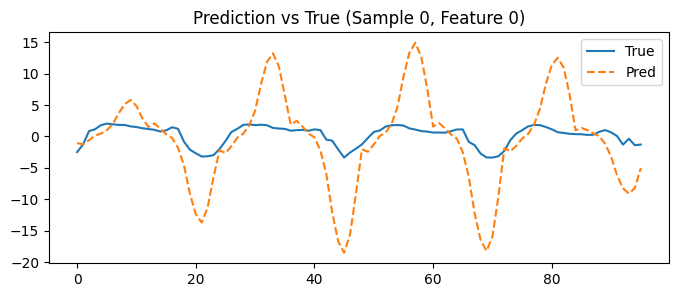

In [ ]:
def plot_prediction_vs_truth(y_true, y_pred, sample_idx=0, feature_idx=0):
    """
    y_true, y_pred: (N, pred_len, D)
    sample_idx: ÌÖåÏä§Ìä∏ÏÖã ÎÇ¥ Î™áÎ≤àÏß∏ ÏÉòÌîå (ÏúàÎèÑÏö∞)
    feature_idx: Î≥ÄÏàò index (ex. 0=OT)
    """
    true_seq = y_true[sample_idx, :, feature_idx]
    pred_seq = y_pred[sample_idx, :, feature_idx]
    plt.figure(figsize=(8, 3))
    plt.plot(true_seq, label='True')
    plt.plot(pred_seq, label='Pred', linestyle='--')
    plt.title(f"Prediction vs True (Sample {sample_idx}, Feature {feature_idx})")
    plt.legend()
    plt.show()

# ÏÇ¨Ïö© ÏòàÏãú
plot_prediction_vs_truth(y_true, y_pred, sample_idx=0, feature_idx=0)


In [ ]:
def pa_at_k_percent(y_true, y_scores, k_percent):
    n = len(y_true)
    k = int(n * k_percent / 100)  # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïùò k%Ïóê Ìï¥ÎãπÌïòÎäî Í∞úÏàò

    if k == 0:
        return 0.0

    idx_sorted = np.argsort(-y_scores)  # Ïù¥ÏÉÅÏπò Ï†êÏàò ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨
    top_k_idx = idx_sorted[:k]
    pa_k = y_true[top_k_idx].sum() / k  # ÏÉÅÏúÑ kÍ∞ú Ï§ë Ïã§Ï†ú Ïù¥ÏÉÅÏπò ÎπÑÏú®
    return pa_k

y_true = fine_tuning_test_metrics[2].flatten()  # Ï†ïÎãµ (0:Ï†ïÏÉÅ, 1:Ïù¥ÏÉÅÏπò)
y_scores = fine_tuning_test_metrics[1].flatten()  # Î™®Îç∏ Ï∂úÎ†• anomaly Ï†êÏàò (ÎÜíÏùÑÏàòÎ°ù Ïù¥ÏÉÅÏπòÏùº ÌôïÎ•†)

# ÌçºÏÑºÌä∏ Í∞íÏúºÎ°ú ÏÑ§Ï†ï
k_percent_values = [1, 5, 10, 20]  # ÏÉÅÏúÑ 1%, 5%, 10%, 20%
for k_percent in k_percent_values:
    pa_k = pa_at_k_percent(y_true, y_scores, k_percent)
    print(f"PA%{k_percent}: {pa_k:.4f}")

# Ï∂îÍ∞Ä Ï†ïÎ≥¥ Ï∂úÎ†•
total_anomalies = y_true.sum()
total_data = len(y_true)
anomaly_ratio = total_anomalies / total_data
print(f"\nÏ†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ïàò: {total_data}")
print(f"Ïã§Ï†ú Ïù¥ÏÉÅÏπò Ïàò: {total_anomalies}")
print(f"Ïã§Ï†ú Ïù¥ÏÉÅÏπò ÎπÑÏú®: {anomaly_ratio:.4f}")

PA%1: 0.8613
PA%5: 0.8879
PA%10: 0.8329
PA%20: 0.6196

Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ïàò: 2213568
Ïã§Ï†ú Ïù¥ÏÉÅÏπò Ïàò: 93903.109375
Ïã§Ï†ú Ïù¥ÏÉÅÏπò ÎπÑÏú®: 0.0424


In [ ]:
def pa_at_k(y_true, y_scores, K):
    idx_sorted = np.argsort(-y_scores)  # Ïù¥ÏÉÅÏπò Ï†êÏàò ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨
    top_k_idx = idx_sorted[:K]
    accuracy = y_true[top_k_idx].sum() / K
    return accuracy


In [ ]:
y_true = fine_tuning_test_metrics[2].flatten()  # Ï†ïÎãµ (0:Ï†ïÏÉÅ, 1:Ïù¥ÏÉÅÏπò)
y_scores = fine_tuning_test_metrics[1].flatten()  # Î™®Îç∏ Ï∂úÎ†• anomaly Ï†êÏàò (ÎÜíÏùÑÏàòÎ°ù Ïù¥ÏÉÅÏπòÏùº ÌôïÎ•†)

K_values = [0, 50, 100]
for K in K_values:
    if K > 0:
        pa_k = pa_at_k(y_true, y_scores, K)
        print(f"PA@{K}: {pa_k:.4f}")


PA@50: 0.8223
PA@100: 0.9085


y_trueÏùò Í≥†Ïú†Í∞í: [-3.7379696 -3.7317257 -3.7253036 ...  3.370874   3.4291358  3.457789 ]
y_trueÍ∞Ä Ïù¥ÏßÑÍ∞íÏù¥ ÏïÑÎãôÎãàÎã§. Ïù¥ÏßÑÌôîÍ∞Ä ÌïÑÏöîÌï©ÎãàÎã§.
Ï§ëÏïôÍ∞í 0.07186368852853775ÏùÑ ÏûÑÍ≥ÑÍ∞íÏúºÎ°ú ÏÇ¨Ïö©ÌïòÏó¨ Ïù¥ÏßÑÌôîÌï©ÎãàÎã§.
Ïù¥ÏßÑÌôî ÌõÑ ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: 0: 1107441, 1: 1106127


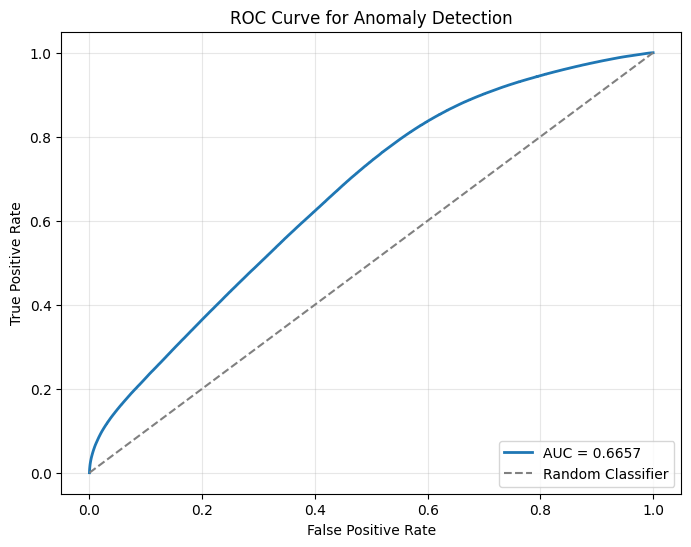

ROC-AUC score: 0.6657


(array([0.        , 0.        , 0.        , ..., 0.99990519, 0.99990519,
        1.        ]),
 array([0.00000000e+00, 9.04055321e-07, 1.34704243e-04, ...,
        9.99999096e-01, 1.00000000e+00, 1.00000000e+00]),
 array([        inf,  0.8254125 ,  0.65821916, ..., -1.0502317 ,
        -1.0507021 , -1.1818993 ], dtype=float32),
 np.float64(0.6657099338198125))

In [ ]:
def plot_roc_curve(y_true, y_scores, threshold=None):
    """
    ROC curveÎ•º ÌîåÎ°úÌåÖÌïòÎäî Ìï®Ïàò

    Parameters:
    -----------
    y_true : array-like
        Ïã§Ï†ú ÎùºÎ≤® (Ïù¥ÏßÑÍ∞í 0 ÎòêÎäî 1Ïù¥Ïñ¥Ïïº Ìï®)
    y_scores : array-like
        ÏòàÏ∏° Ï†êÏàò (Ïó∞ÏÜçÍ∞í)
    threshold : float, optional
        Ïó∞ÏÜçÌòï y_trueÎ•º Ïù¥ÏßÑÌôîÌï† Îïå ÏÇ¨Ïö©Ìï† ÏûÑÍ≥ÑÍ∞í
    """

    # y_trueÍ∞Ä Ïù¥ÏßÑÍ∞íÏù∏ÏßÄ ÌôïÏù∏
    unique_values = np.unique(y_true)

    if len(unique_values) > 2 or not all(val in [0, 1] for val in unique_values):
        print(f"y_trueÏùò Í≥†Ïú†Í∞í: {unique_values}")
        print("y_trueÍ∞Ä Ïù¥ÏßÑÍ∞íÏù¥ ÏïÑÎãôÎãàÎã§. Ïù¥ÏßÑÌôîÍ∞Ä ÌïÑÏöîÌï©ÎãàÎã§.")

        # thresholdÍ∞Ä Ï†úÍ≥µÎêòÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ Ï§ëÏïôÍ∞í ÏÇ¨Ïö©
        if threshold is None:
            threshold = np.median(y_true)
            print(f"Ï§ëÏïôÍ∞í {threshold}ÏùÑ ÏûÑÍ≥ÑÍ∞íÏúºÎ°ú ÏÇ¨Ïö©ÌïòÏó¨ Ïù¥ÏßÑÌôîÌï©ÎãàÎã§.")

        # Ïù¥ÏßÑÌôî ÏàòÌñâ
        y_true_binary = (y_true > threshold).astype(int)
        print(f"Ïù¥ÏßÑÌôî ÌõÑ ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: 0: {sum(y_true_binary==0)}, 1: {sum(y_true_binary==1)}")
    else:
        y_true_binary = y_true

    try:
        # ROC curve Í≥ÑÏÇ∞
        fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
        auc_score = roc_auc_score(y_true_binary, y_scores)

        # ÌîåÎ°Ø ÏÉùÏÑ±
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', linewidth=2)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Anomaly Detection')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()

        print(f"ROC-AUC score: {auc_score:.4f}")

        return fpr, tpr, thresholds, auc_score

    except Exception as e:
        print(f"Ïò§Î•ò Î∞úÏÉù: {e}")
        print("y_scoresÏùò Î∂ÑÌè¨Î•º ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî:")
        print(f"  - Î≤îÏúÑ: [{np.min(y_scores):.4f}, {np.max(y_scores):.4f}]")
        print(f"  - Í≥†Ïú†Í∞í Í∞úÏàò: {len(np.unique(y_scores))}")
        return None, None, None, None
plot_roc_curve(y_true, y_scores)

# ÏÇ¨Ïö© ÏòàÏãú 1: y_trueÍ∞Ä Ïù¥ÎØ∏ Ïù¥ÏßÑÍ∞íÏù∏ Í≤ΩÏö∞
# y_true = np.array([0, 1, 1, 0, 1, 0, 1, 0])
# y_scores = np.array([0.1, 0.8, 0.9, 0.2, 0.7, 0.3, 0.95, 0.05])
# plot_roc_curve(y_true, y_scores)

# ÏÇ¨Ïö© ÏòàÏãú 2: y_trueÍ∞Ä Ïó∞ÏÜçÍ∞íÏù∏ Í≤ΩÏö∞ (ÏûêÎèô Ïù¥ÏßÑÌôî)
# y_true = np.array([0.1, 0.8, 0.9, 0.2, 0.7, 0.3, 0.95, 0.05])
# y_scores = np.array([0.2, 0.7, 0.8, 0.3, 0.6, 0.4, 0.9, 0.1])
# plot_roc_curve(y_true, y_scores)

# ÏÇ¨Ïö© ÏòàÏãú 3: ÌäπÏ†ï ÏûÑÍ≥ÑÍ∞íÏúºÎ°ú Ïù¥ÏßÑÌôî
# y_true = np.array([0.1, 0.8, 0.9, 0.2, 0.7, 0.3, 0.95, 0.05])
# y_scores = np.array([0.2, 0.7, 0.8, 0.3, 0.6, 0.4, 0.9, 0.1])
# plot_roc_curve(y_true, y_scores, threshold=0.5)

In [46]:
def evaluate_classification(fine_tuning_test_metrics):
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    # fine_tuning_test_metricsÍ∞Ä ÌäúÌîåÏù¥Î©¥ Î∂ÑÎ¶¨
    if isinstance(fine_tuning_test_metrics, tuple):
        print("tuple length:", len(fine_tuning_test_metrics))
        for i, v in enumerate(fine_tuning_test_metrics):
            print(f"  [{i}] type: {type(v)}, shape: {getattr(v, 'shape', None)}")

        if len(fine_tuning_test_metrics) == 4:
            avg_loss, avg_acc, all_preds, all_targets = fine_tuning_test_metrics
        else:
            print("ÏßÄÏõêÌïòÏßÄ ÏïäÎäî ÌäúÌîå Íµ¨Ï°∞ÏûÖÎãàÎã§.")
            return
    else:
        print("Í≤∞Í≥º Íµ¨Ï°∞Í∞Ä ÏòàÏÉÅÍ≥º Îã§Î¶Ñ:", type(fine_tuning_test_metrics))
        print(fine_tuning_test_metrics)
        return

    print("==== [Classification Results] ====")
    acc = accuracy_score(all_targets, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds))
    cm = confusion_matrix(all_targets, all_preds)

    # Confusion Matrix ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

tuple length: 4
  [0] type: <class 'float'>, shape: None
  [1] type: <class 'float'>, shape: None
  [2] type: <class 'numpy.ndarray'>, shape: (316224,)
  [3] type: <class 'numpy.ndarray'>, shape: (316224,)
==== [Classification Results] ====
Test Accuracy: 0.2862
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10291
           1       0.51      0.00      0.01     55432
           2       0.17      0.60      0.27     34567
           3       0.13      0.09      0.11     24577
           4       0.26      0.03      0.05    108784
           5       0.40      0.78      0.53     82573
           6       0.00      0.00      0.00         0

    accuracy                           0.29    316224
   macro avg       0.21      0.21      0.14    316224
weighted avg       0.31      0.29      0.19    316224



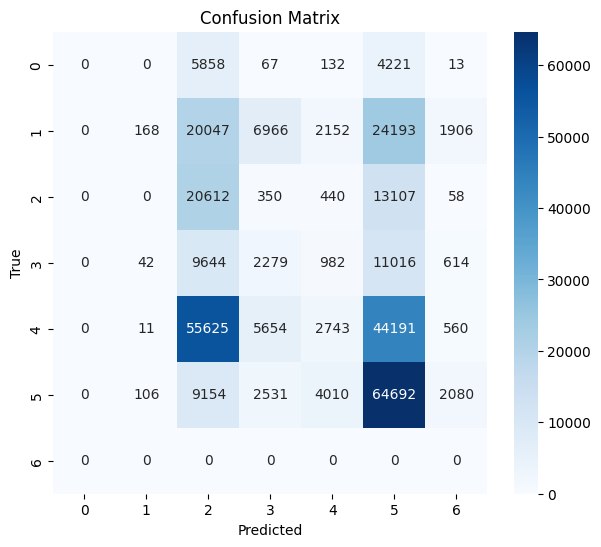

In [47]:
evaluate_classification(fine_tuning_test_metrics)


# Î™®Îç∏ ÌïúÍ≥ÑÏ†êÍ≥º Í∞úÏÑ†Î∞©Ïïà

## Î™®Îç∏ÌïúÍ≥ÑÏ†ê


*   Diffusion model ÏùÑ ÏßÅÏ†ë ÌôúÏö©ÌñàÍ∏∞Ïóê 2Ï∞®ÏõêÏúºÎ°ú ÎßåÎì† Îç∞Ïù¥ÌÑ∞ Ïù∏ÏΩîÎî©Ïùò ÌïúÍ≥Ñ
*   ÎπÑÍµêÏ†Å ÍπäÏùÄ Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌñàÍ∏∞Ïóê Î∞úÏÉùÌïòÎäî Ïò§Î≤ÑÌîºÌåÖ Î¨∏Ï†ú
*   Ï†úÎåÄÎ°ú Îêú Diffusion modelÏùò Í≤ΩÏö∞ ÌóàÏö© Ïù¥ÏÉÅÏùò Î≥µÏû°ÎèÑÎ°ú Ïù∏Ìïú ÌïôÏäµ Î¨∏Ï†ú  
*   Îã§Î•∏ ÌÉúÏä§ÌÅ¨Î•º Í∏∞Ï¥à Î™®Îç∏ ÏûêÏ≤¥Ïùò ÏÑ±Îä•Ïóê ÏùòÏ°¥ÌïòÎäî Î¨∏Ï†ú  

## Í∞úÏÑ†Î∞©Ïïà

*  1D ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞Î•º Ìï©Î¶¨Ï†ÅÏúºÎ°ú 2D Ïù∏ÏΩîÎî©
*  1D ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞Î•º Ïù¥Ïö©Ìïú Bidirectional-LSTM ÌòπÏùÄ BVAE ÏÇ¨Ïö©
*  ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ïÏùÑ ÌÜµÌïú Ïò§Î≤ÑÌîºÌåÖ Ìï¥ÏÜå
*  Ïó¨ÌÉÄ ÏµúÏã† Diffusiom modelÏóê Ï§ÄÌïòÎäî Î™®Îç∏ ÏÇ¨Ïö© Î∞è Í≤ΩÎüâÌôî Î∞©Ïãù Ï†ÅÏö©
*  Í∞ÅÍ∞ÅÏùò ÌÉúÏä§ÌÅ¨Ïóê ÎåÄÌïú Ìï©Î¶¨Ï†ÅÏù∏ ÎîîÏΩîÎçî ÌôúÏö©
*  Î∂ÄÏ°±Ìï† Ïàò ÏûàÎäî ÌëúÌòÑÎ†•ÏùÑ ÎäòÎ¶¨Í∏∞ ÏúÑÌïú Ïñ¥ÌÖêÏÖò Í∏∞Ï¥à Î™®Îç∏ ÏÇ¨Ïö©